In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision import transforms
from torch.nn.functional import relu
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import math

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") #using gpu
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda:0


In [3]:
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

Minimum value: 0.0117647061124444
Maximum value: 1.0


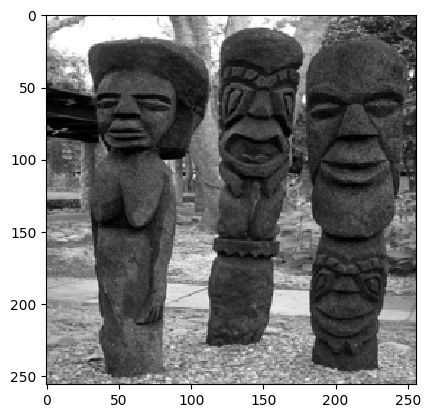

In [4]:
image = Image.open("blurImages/test001.png")
testOutput = preprocess(image).unsqueeze(0)

min_value = np.min(testOutput.squeeze(0).cpu().numpy())
max_value = np.max(testOutput.squeeze(0).cpu().numpy())
print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")
plt.imshow(testOutput.squeeze().numpy(),cmap='gray',interpolation='none')

In [5]:
class UNetDenoise(nn.Module):
    #layers definition
    def __init__(self): #constructor for uNetDenoise
        super().__init__() #constructor of parent class to init inherited attributes
        #Encoder portion, with 256x256x3 input. Padding: same for 3x3 convolutions

        #1st downsample layer
        self.conv11 = nn.Conv2d(2,64,kernel_size=3, padding=1) #dataset images are black and white
        self.conv12 = nn.Conv2d(64,64, kernel_size=3, padding=1) #keep padding same, (kernselSize-1)/2
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        #2nd downsample layer
        self.conv21 = nn.Conv2d(64,128,kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(128,128,kernel_size=3, padding=1)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        #3rd downsample layer
        self.conv31 = nn.Conv2d(128,256,kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(256,256,kernel_size=3, padding=1)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2)

        #4th downsample layer
        self.conv41 = nn.Conv2d(256,512,kernel_size=3, padding=1)
        self.conv42 = nn.Conv2d(512,512,kernel_size=3, padding=1)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2)

        #bottle neck
        self.conv51 = nn.Conv2d(512,1024,kernel_size=3, padding=1)
        self.conv52 = nn.Conv2d(1024,1024,kernel_size=3, padding=1)

        #upsample 1
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #1024, but half 
        self.u11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.u12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        #upsample 2
        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.u21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.u22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        #upsample 3
        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.u31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.u32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        #upsample 4
        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.u41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.u42 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        #encoder forward
        xconv11 = relu(self.conv11(x))
        xconv12 = relu(self.conv12(xconv11))
        xpool1 = self.pool1(xconv12)

        xconv21 = relu(self.conv21(xpool1))
        xconv22 = relu(self.conv22(xconv21))
        xpool2 = self.pool2(xconv22)

        xconv31 = relu(self.conv31(xpool2))
        xconv32 = relu(self.conv32(xconv31))
        xpool3 = self.pool3(xconv32)

        xconv41 = relu(self.conv41(xpool3))
        xconv42 = relu(self.conv42(xconv41))
        xpool4 = self.pool4(xconv42)

        xconv51 = relu(self.conv51(xpool4))
        xconv52 = relu(self.conv52(xconv51))

        #decoder forward 
        xup1 = self.upconv1(xconv52)
        xu11 = torch.cat([xup1, xconv42], dim=1)
        xd11 = relu(self.u11(xu11))
        xd12 = relu(self.u12(xd11))

        xup2 = self.upconv2(xd12)
        xu22 = torch.cat([xup2, xconv32], dim=1)
        xd21 = relu(self.u21(xu22))
        xd22 = relu(self.u22(xd21))

        xup3 = self.upconv3(xd22)
        xu33 = torch.cat([xup3, xconv22], dim=1)
        xd31 = relu(self.u31(xu33))
        xd32 = relu(self.u32(xd31))

        xup4 = self.upconv4(xd32)
        xu44 = torch.cat([xup4, xconv12], dim=1)
        xd41 = relu(self.u41(xu44))
        xd42 = relu(self.u42(xd41))

        return xd42

In [6]:
kernel_size = 9
if kernel_size%2 == 0: #kernel size should be odd
    kernel_size = kernel_size-1

In [7]:
def create_gaussian_kernel(kernel_size=9, sigma=1.5):
    
    x = torch.arange(kernel_size) - (kernel_size - 1) / 2
    y = x.view(kernel_size, 1)
    x2y2 = x**2 + y**2
    
    gaussian_kernel = torch.exp(-x2y2 / (2 * sigma**2))
    gaussian_kernel = gaussian_kernel / (2 * np.pi * sigma**2)
    
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
    return gaussian_kernel

In [8]:
#noise level map
def genNoiseMap(image, sigmaNorm):
    noiselvlMap = torch.full_like(image, sigmaNorm)
    return noiselvlMap
def combineImgandMap(imageNoised, noiselvlMap): #input image needs to be noised
    combinedInput = torch.cat((imageNoised, noiselvlMap), dim=1)
    return combinedInput
def addNoiseMap(imageNoised, sigmaNorm): #image needs to be noised, sigma should be normalized?
    noiselvlMap = genNoiseMap(imageNoised, sigmaNorm)
    return combineImgandMap(imageNoised, noiselvlMap)

In [9]:
class BlurModel(nn.Module):
    def __init__(self):
        super(BlurModel, self).__init__()
        
        self.k= create_gaussian_kernel(kernel_size, 1.5)

        self.k = self.k.view(1,1,kernel_size,kernel_size)
        self.k = self.k.to(device)
    # def forward(self, x, sigma=0):
    #     # A y

    #     #need new padding size with larger kernel
    #     padding_size = kernel_size//2
        
    #     x_padded = F.pad(x, (padding_size,padding_size,padding_size,padding_size), mode='circular')
    #     #applying blur and noise
    #     y = F.conv2d(x_padded, self.k) + sigma * torch.randn_like(x)
    #     return y

    def forward(self, x):
        # A y

        #need new padding size with larger kernel
        padding_size = kernel_size//2
        
        x_padded = F.pad(x, (padding_size,padding_size,padding_size,padding_size), mode='circular')
        #applying blur without noise
        y = F.conv2d(x_padded, self.k)
        return y
    
    def tran(self, y):
        # A^T y
#         x = NotImplemented # hint: transpose the blur kernel
        self.k = torch.transpose(self.k, 0, 1)

        #need new padding size with larger kernel
        padding_size = kernel_size//2
        
        y_padded = F.pad(y, (padding_size, padding_size, padding_size, padding_size), mode='circular')
        #kTranposed = self.k.t()
        x = F.conv2d(y_padded, self.k, padding=0) #self.k is symmetric
        return x
    
    def grad(self, x, y):
        # gradient of 0.5 || Ax - y ||^2 --> grad = A^T(Ax - y)
        g = self.tran( self.forward(x) - y )
        return g

    def calcLoss(self, x, y):
        diff = self.forward(x) - y
        diffSquared = diff ** 2
        return 0.5*torch.sum(diffSquared)


In [10]:
def psnrCalc(mse, max):
    return 10*np.log10((max**2)/mse)


In [11]:
def run_PnP_ISTA(
             x0,
             A, 
             denoiser,
             meas, 
             stepsize,
             gt_img, 
             max_iter,
             sigmaNoiseMap,
             meas_sigma,
            ):
    # ############################
    # A basic implementation of PnP ISTA
    # ############################

    #initializing and adding noise
    x = x0 + meas_sigma * torch.randn_like(x0) #put it outside of the algorithm, with the blur kernel
    with torch.no_grad():
        for i in tqdm(range(max_iter)):
            # Look at PnP ISTA update steps
            
            z = x - stepsize*A.grad(x, meas) #prev x - stepsize*grad(prev x)

            #adding noise map to z:
            z = addNoiseMap(z, sigmaNoiseMap)

            #plug into denoiser
            x = denoiser(z)
        
            #Feel free to add psnr/ssim tracking
            #track loss of (y-AX)^2
            #check if fista is running properly: set x=z, initailize image to zeros, simga=0 and you'll converge
            if i % 10 == 0:
                gt_img_np = gt_img.cpu().detach().numpy() if gt_img.is_cuda else gt_img.numpy()
                x_np = x.cpu().detach().numpy() if x.is_cuda else x.detach().numpy()
                meas_np = meas.cpu().detach().numpy() if meas.is_cuda else x.detach().numpy()
                #psnr of output
                mseTerm = mse(gt_img_np,x_np)
                curPsnr = psnrCalc(mseTerm, 1)
                curLoss = A.calcLoss(x, meas)
        
                #psnr of measurement
                mseTermMeas = mse(gt_img_np,meas_np)
                curPsnrMeas = psnrCalc(mseTermMeas, 1)

                psnrList.append(curPsnr)
                lossList.append(curLoss) #x is clean image, y is measurement
                print(f"At iter {i}, loss is: {curLoss}, PSNR of output is: {curPsnr}, PSNR of input is: {curPsnrMeas}");
    return x

In [12]:
findBestStepSize = False

In [13]:
max_iter = 200
stepsize = [2, 1, 0.9, 0.8, 0.5, 0.3, 0.1, 0.05, 0.01] # play with this
meas_sigma = 15 / 255 # play with this (note that it does not need to be same as the sigma you used for training)
bestPsnr = float('-inf')
bestStepSize = 0
#sigma for noise map
sigmaSampled = torch.randint(1,50,(1,1)).item() #each image have diff sigma
sigmaNoiseMap = sigmaSampled/255

A = BlurModel().to(device) # forward model

clean_img = preprocess(image).unsqueeze(0)
clean_img = clean_img.to(device)
blurry_img = A(clean_img)

network = UNetDenoise()
network.load_state_dict(torch.load('denoiserModelBestWeightswNoiseMap.pth')) # Your NN you trained 
#denoiserFinalWeights.pth denoiserModelBestWeights.pth denoiserFinalWeightsEarlyStopped.pth denoiserModelBestWeightsEarlyStopped.pth denoiserFinalWeightswNoiseMap.pth 
network.eval()

#x0 = torch.zeros_like(blurry_img)
x0 = blurry_img
network.to(device)
blurry_img = blurry_img.to(device)

x0 = x0.to(device)

  1%|          | 6/500 [00:00<00:08, 59.18it/s]

At iter 0, loss is: 6.700823783874512, PSNR of output is: 24.672600730378228, PSNR of input is: 24.799891158716747


  2%|▏         | 12/500 [00:00<00:13, 35.44it/s]

At iter 10, loss is: 5.093928813934326, PSNR of output is: 25.048808000030135, PSNR of input is: 24.799891158716747


  4%|▍         | 21/500 [00:00<00:12, 39.24it/s]

At iter 20, loss is: 5.123293876647949, PSNR of output is: 25.03765659560954, PSNR of input is: 24.799891158716747
At iter 30, loss is: 5.13728141784668, PSNR of output is: 25.02956968776946, PSNR of input is: 24.799891158716747


 10%|█         | 51/500 [00:01<00:09, 45.45it/s]

At iter 40, loss is: 5.143423080444336, PSNR of output is: 25.02525503844279, PSNR of input is: 24.799891158716747
At iter 50, loss is: 5.145162105560303, PSNR of output is: 25.023602273086247, PSNR of input is: 24.799891158716747


 14%|█▍        | 71/500 [00:01<00:09, 46.48it/s]

At iter 60, loss is: 5.1448869705200195, PSNR of output is: 25.02343080489004, PSNR of input is: 24.799891158716747
At iter 70, loss is: 5.1438775062561035, PSNR of output is: 25.023920600017746, PSNR of input is: 24.799891158716747


 18%|█▊        | 91/500 [00:02<00:08, 47.00it/s]

At iter 80, loss is: 5.142870903015137, PSNR of output is: 25.024532404566003, PSNR of input is: 24.799891158716747
At iter 90, loss is: 5.142126560211182, PSNR of output is: 25.025041876138403, PSNR of input is: 24.799891158716747


 20%|██        | 101/500 [00:02<00:08, 47.13it/s]

At iter 100, loss is: 5.141698837280273, PSNR of output is: 25.025378591330632, PSNR of input is: 24.799891158716747


 22%|██▏       | 111/500 [00:02<00:08, 47.15it/s]

At iter 110, loss is: 5.1415205001831055, PSNR of output is: 25.025547940247055, PSNR of input is: 24.799891158716747


 24%|██▍       | 121/500 [00:02<00:08, 47.10it/s]

At iter 120, loss is: 5.141502380371094, PSNR of output is: 25.025596110442784, PSNR of input is: 24.799891158716747


 26%|██▌       | 131/500 [00:02<00:07, 47.06it/s]

At iter 130, loss is: 5.141558647155762, PSNR of output is: 25.02557738489303, PSNR of input is: 24.799891158716747


 28%|██▊       | 141/500 [00:03<00:07, 47.10it/s]

At iter 140, loss is: 5.141631126403809, PSNR of output is: 25.025534581989266, PSNR of input is: 24.799891158716747


 32%|███▏      | 161/500 [00:03<00:07, 46.97it/s]

At iter 150, loss is: 5.141687870025635, PSNR of output is: 25.025493711720618, PSNR of input is: 24.799891158716747
At iter 160, loss is: 5.141720771789551, PSNR of output is: 25.025466140453947, PSNR of input is: 24.799891158716747


 34%|███▍      | 171/500 [00:03<00:07, 46.97it/s]

At iter 170, loss is: 5.141731262207031, PSNR of output is: 25.025453294967047, PSNR of input is: 24.799891158716747


 36%|███▌      | 181/500 [00:03<00:06, 47.04it/s]

At iter 180, loss is: 5.141727924346924, PSNR of output is: 25.025451094604875, PSNR of input is: 24.799891158716747


 38%|███▊      | 191/500 [00:04<00:06, 47.09it/s]

At iter 190, loss is: 5.141718864440918, PSNR of output is: 25.025455073993168, PSNR of input is: 24.799891158716747


 42%|████▏     | 211/500 [00:04<00:06, 46.96it/s]

At iter 200, loss is: 5.141709327697754, PSNR of output is: 25.025460881155063, PSNR of input is: 24.799891158716747
At iter 210, loss is: 5.141702651977539, PSNR of output is: 25.02546585392118, PSNR of input is: 24.799891158716747


 44%|████▍     | 221/500 [00:04<00:05, 46.97it/s]

At iter 220, loss is: 5.141698837280273, PSNR of output is: 25.02546929366094, PSNR of input is: 24.799891158716747


 46%|████▌     | 231/500 [00:04<00:05, 47.04it/s]

At iter 230, loss is: 5.141696453094482, PSNR of output is: 25.025471083681733, PSNR of input is: 24.799891158716747


 48%|████▊     | 241/500 [00:05<00:05, 47.08it/s]

At iter 240, loss is: 5.141696929931641, PSNR of output is: 25.02547166850158, PSNR of input is: 24.799891158716747


 50%|█████     | 251/500 [00:05<00:05, 46.98it/s]

At iter 250, loss is: 5.141697883605957, PSNR of output is: 25.025471283105464, PSNR of input is: 24.799891158716747


 52%|█████▏    | 261/500 [00:05<00:05, 46.98it/s]

At iter 260, loss is: 5.141698837280273, PSNR of output is: 25.025470772633142, PSNR of input is: 24.799891158716747


 54%|█████▍    | 271/500 [00:05<00:04, 47.05it/s]

At iter 270, loss is: 5.14169979095459, PSNR of output is: 25.02547017355241, PSNR of input is: 24.799891158716747


 56%|█████▌    | 281/500 [00:06<00:04, 46.89it/s]

At iter 280, loss is: 5.14169979095459, PSNR of output is: 25.025469794458168, PSNR of input is: 24.799891158716747


 58%|█████▊    | 291/500 [00:06<00:04, 46.92it/s]

At iter 290, loss is: 5.141700744628906, PSNR of output is: 25.025469553961535, PSNR of input is: 24.799891158716747


 60%|██████    | 301/500 [00:06<00:04, 46.93it/s]

At iter 300, loss is: 5.141700744628906, PSNR of output is: 25.025469470936667, PSNR of input is: 24.799891158716747


 64%|██████▍   | 321/500 [00:06<00:03, 46.89it/s]

At iter 310, loss is: 5.141700267791748, PSNR of output is: 25.025469530396695, PSNR of input is: 24.799891158716747
At iter 320, loss is: 5.14169979095459, PSNR of output is: 25.02546951697081, PSNR of input is: 24.799891158716747


 68%|██████▊   | 341/500 [00:07<00:03, 47.21it/s]

At iter 330, loss is: 5.14169979095459, PSNR of output is: 25.025469500274248, PSNR of input is: 24.799891158716747
At iter 340, loss is: 5.141700267791748, PSNR of output is: 25.025469585673218, PSNR of input is: 24.799891158716747


 72%|███████▏  | 361/500 [00:07<00:02, 47.32it/s]

At iter 350, loss is: 5.14169979095459, PSNR of output is: 25.025469766676217, PSNR of input is: 24.799891158716747
At iter 360, loss is: 5.14169979095459, PSNR of output is: 25.025469728205803, PSNR of input is: 24.799891158716747


 76%|███████▌  | 381/500 [00:08<00:02, 47.44it/s]

At iter 370, loss is: 5.14169979095459, PSNR of output is: 25.025469767638203, PSNR of input is: 24.799891158716747
At iter 380, loss is: 5.14169979095459, PSNR of output is: 25.02546978202139, PSNR of input is: 24.799891158716747


 78%|███████▊  | 391/500 [00:08<00:02, 47.43it/s]

At iter 390, loss is: 5.14169979095459, PSNR of output is: 25.025469769407614, PSNR of input is: 24.799891158716747


 80%|████████  | 401/500 [00:08<00:02, 47.56it/s]

At iter 400, loss is: 5.14169979095459, PSNR of output is: 25.025469817103655, PSNR of input is: 24.799891158716747


 84%|████████▍ | 421/500 [00:09<00:01, 47.44it/s]

At iter 410, loss is: 5.14169979095459, PSNR of output is: 25.025469820254173, PSNR of input is: 24.799891158716747
At iter 420, loss is: 5.14169979095459, PSNR of output is: 25.025469867936806, PSNR of input is: 24.799891158716747


 88%|████████▊ | 441/500 [00:09<00:01, 47.43it/s]

At iter 430, loss is: 5.14169979095459, PSNR of output is: 25.02546986128543, PSNR of input is: 24.799891158716747
At iter 440, loss is: 5.14169979095459, PSNR of output is: 25.025469915985052, PSNR of input is: 24.799891158716747


 90%|█████████ | 451/500 [00:09<00:01, 47.43it/s]

At iter 450, loss is: 5.141700267791748, PSNR of output is: 25.025469870932724, PSNR of input is: 24.799891158716747


 92%|█████████▏| 461/500 [00:09<00:00, 47.35it/s]

At iter 460, loss is: 5.14169979095459, PSNR of output is: 25.02546990733162, PSNR of input is: 24.799891158716747


 94%|█████████▍| 471/500 [00:10<00:00, 47.42it/s]

At iter 470, loss is: 5.14169979095459, PSNR of output is: 25.025469864737303, PSNR of input is: 24.799891158716747


 96%|█████████▌| 481/500 [00:10<00:00, 47.49it/s]

At iter 480, loss is: 5.14169979095459, PSNR of output is: 25.0254699022646, PSNR of input is: 24.799891158716747


100%|██████████| 500/500 [00:10<00:00, 47.58it/s]

At iter 490, loss is: 5.141699314117432, PSNR of output is: 25.025469905284137, PSNR of input is: 24.799891158716747


(-0.5, 255.5, 255.5, -0.5)

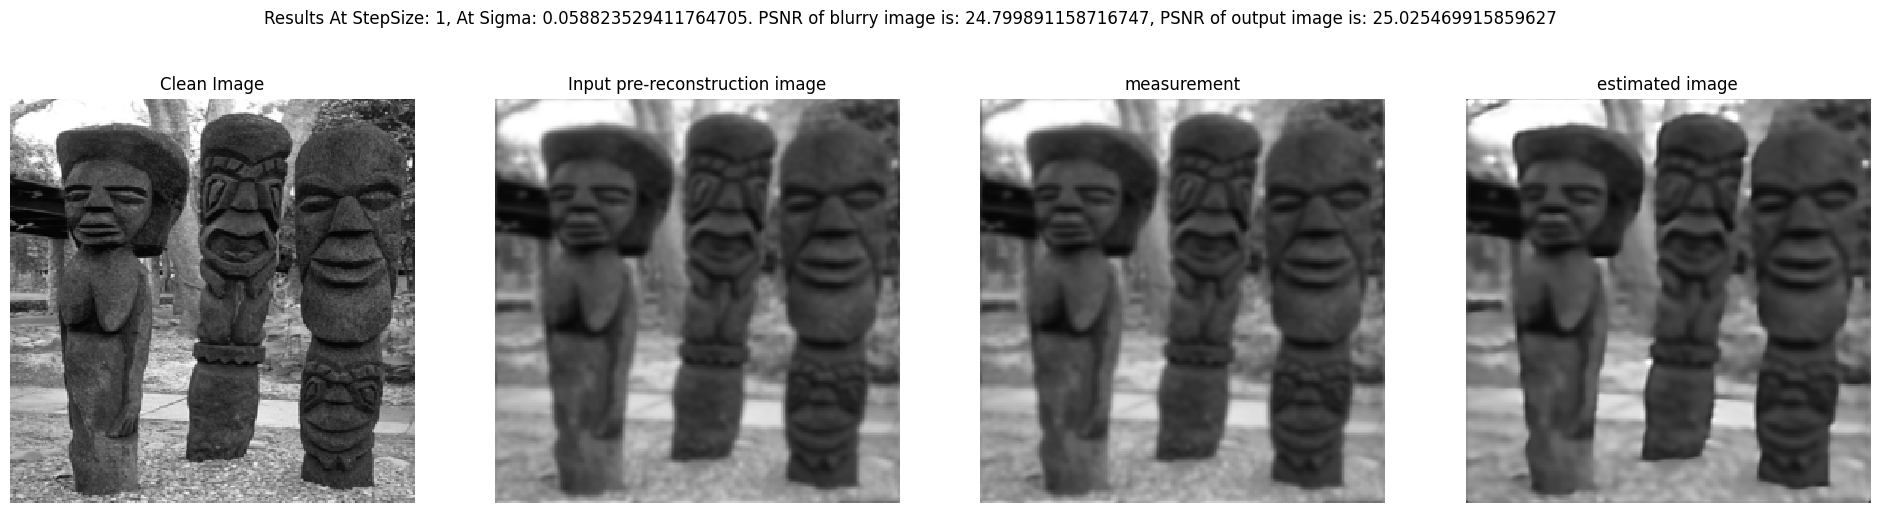

In [14]:
#best step size is found to be 1
lossList = list()
psnrList = list()
recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
                         A = A, 
                         denoiser = network,
                         meas = blurry_img, 
                         stepsize = 1,
                         gt_img = clean_img, 
                         max_iter = 500,
                         sigmaNoiseMap = sigmaNoiseMap,
                         meas_sigma = meas_sigma
                    )

blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon_np = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon_np)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

fig, ax = plt.subplots(1,4, figsize=(24,6))

fig.suptitle(f'Results At StepSize: {1}, At Sigma: {meas_sigma}. PSNR of blurry image is: {finalPsnrMeas}, PSNR of output image is: {finalPsnrOutput}')

ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[0].set_title("Clean Image", fontsize=12)
ax[0].axis('off')
ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[1].set_title("Input pre-reconstruction image", fontsize=12)
ax[1].axis('off')
ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[2].set_title("measurement", fontsize=12)
ax[2].axis('off')
ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[3].set_title("estimated image", fontsize=12)
ax[3].axis('off')

In [15]:
blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

print(f'Final result PSNR of blurred image {finalPsnrMeas}')
print(f'Final result PSNR of reconstructed image {finalPsnrOutput}')

Final result PSNR of blurred image 24.799891158716747
Final result PSNR of reconstructed image 25.025469915859627


In [16]:
import scipy

In [17]:
def objFuncStepSize(stepsize):
    imgRecon = run_PnP_ISTA(x0=x0, A=A, denoiser=network, meas=blurry_img, stepsize=1e-4, gt_img=clean_img, max_iter=200, sigmaNoiseMap = sigmaNoiseMap, meas_sigma=15/255) #pass in sigma,
    blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
    clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.detach().numpy()
    imgRecon_np = imgRecon.cpu().detach().numpy() if isinstance(imgRecon, torch.Tensor) else imgRecon
    mseTermRecon = mse(clean_img_np, imgRecon_np)
    mseTermBlurred = mse(clean_img_np, blurry_img_np)
    return -psnrCalc(mseTermRecon, 1)

In [18]:
bestStepsize = scipy.optimize.fminbound(objFuncStepSize,1e-6,2,xtol=1e-3,maxfun=20,disp=3)

  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.150107383728027, PSNR of output is: 23.98488812180794, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.44it/s]

At iter 10, loss is: 64.66146087646484, PSNR of output is: 21.81453212022358, PSNR of input is: 24.799891158716747
At iter 20, loss is: 133.10342407226562, PSNR of output is: 20.306728434186443, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.75it/s]

At iter 30, loss is: 211.68276977539062, PSNR of output is: 19.152075694049294, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.92it/s]

At iter 40, loss is: 296.4490966796875, PSNR of output is: 18.2108003829271, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.86it/s]

At iter 50, loss is: 383.8365478515625, PSNR of output is: 17.429579643056417, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.90it/s]

At iter 60, loss is: 472.0173034667969, PSNR of output is: 16.77073178853308, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.85it/s]

At iter 70, loss is: 560.098876953125, PSNR of output is: 16.206219633554102, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.14it/s]

At iter 80, loss is: 648.64501953125, PSNR of output is: 15.708815798341053, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 45.93it/s]

At iter 90, loss is: 738.7122802734375, PSNR of output is: 15.257253291848604, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.37it/s]

At iter 100, loss is: 831.590087890625, PSNR of output is: 14.835614442736233, PSNR of input is: 24.799891158716747
At iter 110, loss is: 927.8775634765625, PSNR of output is: 14.435871055586382, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.49it/s]

At iter 120, loss is: 1027.835693359375, PSNR of output is: 14.054275167516403, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.70it/s]

At iter 130, loss is: 1130.087158203125, PSNR of output is: 13.693326701728035, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.59it/s]

At iter 140, loss is: 1234.048583984375, PSNR of output is: 13.350970876995811, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.57it/s]

At iter 150, loss is: 1339.4678955078125, PSNR of output is: 13.021973002161024, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.76it/s]

At iter 160, loss is: 1446.04931640625, PSNR of output is: 12.704218168429126, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.76it/s]

At iter 170, loss is: 1554.67626953125, PSNR of output is: 12.392797216045118, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.69it/s]

At iter 180, loss is: 1670.677978515625, PSNR of output is: 12.064858298278601, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.29it/s]


At iter 190, loss is: 1795.70068359375, PSNR of output is: 11.716041417632663, PSNR of input is: 24.799891158716747
 
 Func-count     x          f(x)          Procedure
    1       0.763933     -11.3768        initial


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.200368881225586, PSNR of output is: 23.988899699232423, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 44.74it/s]

At iter 10, loss is: 64.77696228027344, PSNR of output is: 21.805084462168708, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.27it/s]

At iter 20, loss is: 133.5394287109375, PSNR of output is: 20.289084919036107, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.36it/s]

At iter 30, loss is: 213.06332397460938, PSNR of output is: 19.126345229757064, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 45.33it/s]

At iter 40, loss is: 298.70257568359375, PSNR of output is: 18.181912221166154, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.09it/s]

At iter 50, loss is: 386.0145568847656, PSNR of output is: 17.406244177720776, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.08it/s]

At iter 60, loss is: 473.4964599609375, PSNR of output is: 16.757219765358546, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.08it/s]

At iter 70, loss is: 561.036865234375, PSNR of output is: 16.200698035843534, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.21it/s]

At iter 80, loss is: 648.873291015625, PSNR of output is: 15.71150790605001, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 45.36it/s]

At iter 90, loss is: 737.021484375, PSNR of output is: 15.272018706857084, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.27it/s]

At iter 100, loss is: 826.5208129882812, PSNR of output is: 14.867609362586908, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.33it/s]

At iter 110, loss is: 918.5234375, PSNR of output is: 14.488048197337722, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.57it/s]

At iter 120, loss is: 1014.2286987304688, PSNR of output is: 14.124437407434822, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.79it/s]

At iter 130, loss is: 1113.021240234375, PSNR of output is: 13.776777085376358, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.23it/s]

At iter 140, loss is: 1214.52685546875, PSNR of output is: 13.444801278767653, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.31it/s]

At iter 150, loss is: 1318.79296875, PSNR of output is: 13.126486265773467, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.25it/s]

At iter 160, loss is: 1423.18994140625, PSNR of output is: 12.825730282277322, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.95it/s]

At iter 170, loss is: 1525.937744140625, PSNR of output is: 12.543419500577041, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.25it/s]

At iter 180, loss is: 1629.741943359375, PSNR of output is: 12.272054117051226, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.61it/s]


At iter 190, loss is: 1736.537109375, PSNR of output is: 12.003135422584082, PSNR of input is: 24.799891158716747
    2        1.23607     -11.7509        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.917194366455078, PSNR of output is: 24.000472192549882, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.29it/s]

At iter 10, loss is: 64.6009521484375, PSNR of output is: 21.815418469817338, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.28it/s]

At iter 20, loss is: 133.21005249023438, PSNR of output is: 20.298871870363477, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.56it/s]

At iter 30, loss is: 212.4089813232422, PSNR of output is: 19.138738627839892, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 45.53it/s]

At iter 40, loss is: 298.3697509765625, PSNR of output is: 18.190358808909693, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.58it/s]

At iter 50, loss is: 387.4640197753906, PSNR of output is: 17.399348260197417, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.69it/s]

At iter 60, loss is: 477.3835144042969, PSNR of output is: 16.733119058288878, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.62it/s]

At iter 70, loss is: 566.4384765625, PSNR of output is: 16.167437060356715, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.04it/s]

At iter 80, loss is: 655.1650390625, PSNR of output is: 15.673323913512348, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.33it/s]

At iter 90, loss is: 745.5675659179688, PSNR of output is: 15.2235566429065, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.39it/s]

At iter 100, loss is: 839.030517578125, PSNR of output is: 14.80182838520214, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.76it/s]

At iter 110, loss is: 936.0224609375, PSNR of output is: 14.40109460475465, PSNR of input is: 24.799891158716747
At iter 120, loss is: 1036.12255859375, PSNR of output is: 14.020079356803507, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.89it/s]

At iter 130, loss is: 1137.4749755859375, PSNR of output is: 13.662813996451142, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.72it/s]

At iter 140, loss is: 1239.6591796875, PSNR of output is: 13.325963295675734, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.86it/s]

At iter 150, loss is: 1341.3389892578125, PSNR of output is: 13.010344874016461, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.96it/s]

At iter 160, loss is: 1442.859375, PSNR of output is: 12.713476043477128, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.25it/s]

At iter 170, loss is: 1545.9547119140625, PSNR of output is: 12.42546993038575, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 45.70it/s]

At iter 180, loss is: 1654.05810546875, PSNR of output is: 12.133118590297475, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.00it/s]


At iter 190, loss is: 1768.9111328125, PSNR of output is: 11.82487678963582, PSNR of input is: 24.799891158716747
    3        1.52786     -11.5251        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.018545150756836, PSNR of output is: 23.984902680081888, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.84it/s]

At iter 10, loss is: 64.24050903320312, PSNR of output is: 21.81911744048557, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.67it/s]

At iter 20, loss is: 132.97503662109375, PSNR of output is: 20.301766769388525, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.32it/s]

At iter 30, loss is: 212.5261688232422, PSNR of output is: 19.136404945554922, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 45.74it/s]

At iter 40, loss is: 298.3514404296875, PSNR of output is: 18.188799119230804, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.52it/s]

At iter 50, loss is: 386.7198486328125, PSNR of output is: 17.404161141970114, PSNR of input is: 24.799891158716747
At iter 60, loss is: 475.9322509765625, PSNR of output is: 16.743791181329055, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.90it/s]

At iter 70, loss is: 565.01220703125, PSNR of output is: 16.17878852021043, PSNR of input is: 24.799891158716747
At iter 80, loss is: 653.8214721679688, PSNR of output is: 15.684907059943527, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.30it/s]

At iter 90, loss is: 744.1605834960938, PSNR of output is: 15.237147576171298, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.37it/s]

At iter 100, loss is: 837.4691162109375, PSNR of output is: 14.819442341072545, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.56it/s]

At iter 110, loss is: 934.1076049804688, PSNR of output is: 14.42482664577604, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.75it/s]

At iter 120, loss is: 1033.50244140625, PSNR of output is: 14.05050795539931, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.68it/s]

At iter 130, loss is: 1133.6591796875, PSNR of output is: 13.700369408701258, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.77it/s]

At iter 140, loss is: 1233.032958984375, PSNR of output is: 13.376199214007276, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.83it/s]

At iter 150, loss is: 1330.920166015625, PSNR of output is: 13.07635594902434, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.88it/s]

At iter 160, loss is: 1427.73046875, PSNR of output is: 12.797523484041836, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.04it/s]

At iter 170, loss is: 1524.4403076171875, PSNR of output is: 12.534143540970838, PSNR of input is: 24.799891158716747
At iter 180, loss is: 1623.01611328125, PSNR of output is: 12.277806982990057, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.45it/s]


At iter 190, loss is: 1725.40966796875, PSNR of output is: 12.019882201118467, PSNR of input is: 24.799891158716747
    4        1.19323     -11.7746        parabolic


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.7908935546875, PSNR of output is: 24.00584861070529, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.84it/s]

At iter 10, loss is: 64.32986450195312, PSNR of output is: 21.826096707993266, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.97it/s]

At iter 20, loss is: 133.09820556640625, PSNR of output is: 20.30746205822429, PSNR of input is: 24.799891158716747
At iter 30, loss is: 213.20440673828125, PSNR of output is: 19.13238571511578, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 47.13it/s]

At iter 40, loss is: 299.48541259765625, PSNR of output is: 18.180458540025153, PSNR of input is: 24.799891158716747
At iter 50, loss is: 387.68408203125, PSNR of output is: 17.39830005895214, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.93it/s]

At iter 60, loss is: 476.0898742675781, PSNR of output is: 16.74407597106933, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.66it/s]

At iter 70, loss is: 563.5782470703125, PSNR of output is: 16.188464495998886, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.83it/s]

At iter 80, loss is: 650.7861328125, PSNR of output is: 15.701209411215814, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.87it/s]

At iter 90, loss is: 739.374755859375, PSNR of output is: 15.256578291338688, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.97it/s]

At iter 100, loss is: 830.870849609375, PSNR of output is: 14.83720623138817, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.91it/s]

At iter 110, loss is: 927.1103515625, PSNR of output is: 14.427291823952984, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.99it/s]

At iter 120, loss is: 1029.43359375, PSNR of output is: 14.012758935033858, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.59it/s]

At iter 130, loss is: 1137.8486328125, PSNR of output is: 13.588880351827264, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.38it/s]

At iter 140, loss is: 1250.67333984375, PSNR of output is: 13.176212869767985, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.79it/s]

At iter 150, loss is: 1366.33984375, PSNR of output is: 12.7893755737479, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.14it/s]

At iter 160, loss is: 1483.463623046875, PSNR of output is: 12.425958876587186, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.32it/s]

At iter 170, loss is: 1601.6629638671875, PSNR of output is: 12.081109103638079, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.45it/s]

At iter 180, loss is: 1724.8115234375, PSNR of output is: 11.740272224410607, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.52it/s]


At iter 190, loss is: 1858.26513671875, PSNR of output is: 11.381412285806391, PSNR of input is: 24.799891158716747
    5        1.02925     -11.0092        golden


  6%|▌         | 11/200 [00:00<00:04, 46.84it/s]

At iter 0, loss is: 15.119504928588867, PSNR of output is: 23.99210095610784, PSNR of input is: 24.799891158716747
At iter 10, loss is: 65.01117706298828, PSNR of output is: 21.801750448938932, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.75it/s]

At iter 20, loss is: 134.03652954101562, PSNR of output is: 20.285809629111576, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.85it/s]

At iter 30, loss is: 214.8675537109375, PSNR of output is: 19.108336455167812, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 45.98it/s]

At iter 40, loss is: 302.626953125, PSNR of output is: 18.14793625312734, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.87it/s]

At iter 50, loss is: 392.15350341796875, PSNR of output is: 17.36206937161162, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.53it/s]

At iter 60, loss is: 481.0679016113281, PSNR of output is: 16.710145013346942, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.99it/s]

At iter 70, loss is: 568.18310546875, PSNR of output is: 16.16155394667605, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.30it/s]

At iter 80, loss is: 655.7723999023438, PSNR of output is: 15.676541295808077, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 45.65it/s]

At iter 90, loss is: 745.2678833007812, PSNR of output is: 15.232925813871807, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.65it/s]

At iter 100, loss is: 837.7183837890625, PSNR of output is: 14.817219771601469, PSNR of input is: 24.799891158716747
At iter 110, loss is: 934.2595825195312, PSNR of output is: 14.42014757970243, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.66it/s]

At iter 120, loss is: 1033.8133544921875, PSNR of output is: 14.043016317797008, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.61it/s]

At iter 130, loss is: 1133.839111328125, PSNR of output is: 13.69115909496488, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 45.95it/s]

At iter 140, loss is: 1233.5048828125, PSNR of output is: 13.361635908179657, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.81it/s]

At iter 150, loss is: 1332.7713623046875, PSNR of output is: 13.051305181620048, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.52it/s]

At iter 160, loss is: 1431.41455078125, PSNR of output is: 12.761795131853809, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.45it/s]

At iter 170, loss is: 1531.294921875, PSNR of output is: 12.484606934523592, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 45.33it/s]

At iter 180, loss is: 1634.10009765625, PSNR of output is: 12.211977073524817, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.53it/s]


At iter 190, loss is: 1741.555419921875, PSNR of output is: 11.934228092626036, PSNR of input is: 24.799891158716747
    6         1.1306     -11.6614        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.007707595825195, PSNR of output is: 23.975949478732268, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.57it/s]

At iter 10, loss is: 65.35163116455078, PSNR of output is: 21.799695614145882, PSNR of input is: 24.799891158716747
At iter 20, loss is: 134.74996948242188, PSNR of output is: 20.277599521357324, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.56it/s]

At iter 30, loss is: 214.75144958496094, PSNR of output is: 19.11275834479283, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 45.72it/s]

At iter 40, loss is: 301.18804931640625, PSNR of output is: 18.16404058899544, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.01it/s]

At iter 50, loss is: 389.279541015625, PSNR of output is: 17.38449998214869, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 46.26it/s]

At iter 60, loss is: 478.2659606933594, PSNR of output is: 16.726779849243712, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.56it/s]

At iter 70, loss is: 567.0479736328125, PSNR of output is: 16.16296649692641, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.55it/s]

At iter 80, loss is: 656.171630859375, PSNR of output is: 15.66303406100445, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.55it/s]

At iter 90, loss is: 748.3233642578125, PSNR of output is: 15.193735911042431, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.61it/s]

At iter 100, loss is: 846.2640380859375, PSNR of output is: 14.724982802888665, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.75it/s]

At iter 110, loss is: 952.6818237304688, PSNR of output is: 14.243147134994171, PSNR of input is: 24.799891158716747
At iter 120, loss is: 1066.1170654296875, PSNR of output is: 13.772105988991703, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.75it/s]

At iter 130, loss is: 1182.4144287109375, PSNR of output is: 13.338553169443747, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.43it/s]

At iter 140, loss is: 1298.162353515625, PSNR of output is: 12.94323731349876, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.01it/s]

At iter 150, loss is: 1414.03564453125, PSNR of output is: 12.574968212899392, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.72it/s]

At iter 160, loss is: 1531.360107421875, PSNR of output is: 12.224451512304437, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.46it/s]

At iter 170, loss is: 1649.9873046875, PSNR of output is: 11.887381119724065, PSNR of input is: 24.799891158716747


 96%|█████████▌| 191/200 [00:04<00:00, 45.71it/s]

At iter 180, loss is: 1774.3173828125, PSNR of output is: 11.546920773789708, PSNR of input is: 24.799891158716747
At iter 190, loss is: 1909.2283935546875, PSNR of output is: 11.173619879484152, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.05it/s]


    7        1.20231     -10.8005        parabolic


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.887210845947266, PSNR of output is: 23.979261792211275, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.29it/s]

At iter 10, loss is: 63.60549545288086, PSNR of output is: 21.839664478314006, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.11it/s]

At iter 20, loss is: 132.0009307861328, PSNR of output is: 20.321881825777144, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.11it/s]

At iter 30, loss is: 211.9146728515625, PSNR of output is: 19.145472772850553, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 45.54it/s]

At iter 40, loss is: 298.7337951660156, PSNR of output is: 18.185311570848654, PSNR of input is: 24.799891158716747
At iter 50, loss is: 387.64996337890625, PSNR of output is: 17.396772970596757, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 46.16it/s]

At iter 60, loss is: 476.4855041503906, PSNR of output is: 16.739750468136446, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.80it/s]

At iter 70, loss is: 564.2684326171875, PSNR of output is: 16.183375033613544, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.90it/s]

At iter 80, loss is: 651.4177856445312, PSNR of output is: 15.698168625604465, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.10it/s]

At iter 90, loss is: 739.0458984375, PSNR of output is: 15.261016077099121, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.36it/s]

At iter 100, loss is: 828.091064453125, PSNR of output is: 14.85754862293061, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.48it/s]

At iter 110, loss is: 920.3936157226562, PSNR of output is: 14.473120192211466, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.37it/s]

At iter 120, loss is: 1016.9306640625, PSNR of output is: 14.10030141885144, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.49it/s]

At iter 130, loss is: 1117.3472900390625, PSNR of output is: 13.735983316687586, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.18it/s]

At iter 140, loss is: 1220.9761962890625, PSNR of output is: 13.372309010150111, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.90it/s]

At iter 150, loss is: 1328.330810546875, PSNR of output is: 13.001147337727879, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.22it/s]

At iter 160, loss is: 1437.9071044921875, PSNR of output is: 12.641725200059073, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.99it/s]

At iter 170, loss is: 1549.3330078125, PSNR of output is: 12.303134875435111, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.16it/s]

At iter 180, loss is: 1664.283203125, PSNR of output is: 11.975691900315368, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.98it/s]


At iter 190, loss is: 1785.3858642578125, PSNR of output is: 11.648904068979641, PSNR of input is: 24.799891158716747
    8        1.16931     -11.3383        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.939105033874512, PSNR of output is: 23.97789693076175, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.64it/s]

At iter 10, loss is: 64.55119323730469, PSNR of output is: 21.81640575036251, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.58it/s]

At iter 20, loss is: 133.65988159179688, PSNR of output is: 20.29980561048758, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.56it/s]

At iter 30, loss is: 214.12362670898438, PSNR of output is: 19.127508562209798, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.22it/s]

At iter 40, loss is: 301.6142578125, PSNR of output is: 18.168482934383448, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.73it/s]

At iter 50, loss is: 391.8729248046875, PSNR of output is: 17.373576589099585, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.78it/s]

At iter 60, loss is: 481.8192443847656, PSNR of output is: 16.712592502494704, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.75it/s]

At iter 70, loss is: 570.1046142578125, PSNR of output is: 16.156559541947008, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.34it/s]

At iter 80, loss is: 658.3660888671875, PSNR of output is: 15.66838070128141, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 45.77it/s]

At iter 90, loss is: 747.7070922851562, PSNR of output is: 15.227406284312067, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.43it/s]

At iter 100, loss is: 839.64697265625, PSNR of output is: 14.817082276880127, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.19it/s]

At iter 110, loss is: 934.8373413085938, PSNR of output is: 14.429793297835989, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 44.91it/s]

At iter 120, loss is: 1033.19873046875, PSNR of output is: 14.062090168993224, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 44.77it/s]

At iter 130, loss is: 1132.111083984375, PSNR of output is: 13.720812510515936, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 44.80it/s]

At iter 140, loss is: 1230.577880859375, PSNR of output is: 13.404825968372657, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 44.94it/s]

At iter 150, loss is: 1328.27490234375, PSNR of output is: 13.111065460685627, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 44.98it/s]

At iter 160, loss is: 1423.91455078125, PSNR of output is: 12.841993279203525, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.07it/s]

At iter 170, loss is: 1517.7281494140625, PSNR of output is: 12.593776020582276, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 45.01it/s]

At iter 180, loss is: 1611.928466796875, PSNR of output is: 12.356485286796058, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.16it/s]


At iter 190, loss is: 1707.0069580078125, PSNR of output is: 12.124890252401208, PSNR of input is: 24.799891158716747
    9        1.18409     -11.9161        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.969761848449707, PSNR of output is: 23.99537154306078, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.29it/s]

At iter 10, loss is: 64.26358032226562, PSNR of output is: 21.82453303423987, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.28it/s]

At iter 20, loss is: 132.5743408203125, PSNR of output is: 20.313674266045712, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.19it/s]

At iter 30, loss is: 212.440185546875, PSNR of output is: 19.140594140084218, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.67it/s]

At iter 40, loss is: 299.68109130859375, PSNR of output is: 18.177730912407206, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 44.89it/s]

At iter 50, loss is: 389.07623291015625, PSNR of output is: 17.386094778627722, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 44.95it/s]

At iter 60, loss is: 478.718505859375, PSNR of output is: 16.724893508932265, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.19it/s]

At iter 70, loss is: 567.3076171875, PSNR of output is: 16.165143806678557, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.21it/s]

At iter 80, loss is: 655.916015625, PSNR of output is: 15.674596162602274, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 45.30it/s]

At iter 90, loss is: 746.058837890625, PSNR of output is: 15.229354718744547, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 45.35it/s]

At iter 100, loss is: 839.3370361328125, PSNR of output is: 14.812374521327925, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 45.20it/s]

At iter 110, loss is: 936.373779296875, PSNR of output is: 14.415308338184381, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 45.35it/s]

At iter 120, loss is: 1036.03759765625, PSNR of output is: 14.040523269543176, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 45.39it/s]

At iter 130, loss is: 1135.348876953125, PSNR of output is: 13.69524917286075, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 45.36it/s]

At iter 140, loss is: 1233.333251953125, PSNR of output is: 13.379036893072813, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.33it/s]

At iter 150, loss is: 1330.0146484375, PSNR of output is: 13.08833420830306, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.31it/s]

At iter 160, loss is: 1425.47998046875, PSNR of output is: 12.818578434777052, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.36it/s]

At iter 170, loss is: 1521.4713134765625, PSNR of output is: 12.560820724992006, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 45.34it/s]

At iter 180, loss is: 1619.2421875, PSNR of output is: 12.3084759510073, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.07it/s]


At iter 190, loss is: 1720.2132568359375, PSNR of output is: 12.055282312582229, PSNR of input is: 24.799891158716747
   10        1.17844     -11.8176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.641983032226562, PSNR of output is: 24.034047655951692, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 44.92it/s]

At iter 10, loss is: 63.553531646728516, PSNR of output is: 21.835975856812354, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.24it/s]

At iter 20, loss is: 131.96966552734375, PSNR of output is: 20.316872416830975, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 44.98it/s]

At iter 30, loss is: 211.57022094726562, PSNR of output is: 19.149177635314235, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 45.01it/s]

At iter 40, loss is: 297.4036865234375, PSNR of output is: 18.20042059145053, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.03it/s]

At iter 50, loss is: 384.9100341796875, PSNR of output is: 17.42058362494276, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.11it/s]

At iter 60, loss is: 472.99713134765625, PSNR of output is: 16.763958079030623, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 44.51it/s]

At iter 70, loss is: 561.1407470703125, PSNR of output is: 16.19894226520114, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 44.56it/s]

At iter 80, loss is: 648.4591064453125, PSNR of output is: 15.706169317129344, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 44.72it/s]

At iter 90, loss is: 736.9638671875, PSNR of output is: 15.258902692088911, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 44.83it/s]

At iter 100, loss is: 828.3742065429688, PSNR of output is: 14.838810297565683, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 44.53it/s]

At iter 110, loss is: 924.6145629882812, PSNR of output is: 14.430418727880188, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 44.23it/s]

At iter 120, loss is: 1026.863525390625, PSNR of output is: 14.02052838571649, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 44.60it/s]

At iter 130, loss is: 1136.1673583984375, PSNR of output is: 13.601033603537276, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 44.74it/s]

At iter 140, loss is: 1251.232666015625, PSNR of output is: 13.186335337339887, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.02it/s]

At iter 150, loss is: 1369.3447265625, PSNR of output is: 12.79153981904427, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 44.55it/s]

At iter 160, loss is: 1488.631103515625, PSNR of output is: 12.417647202947453, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 44.71it/s]

At iter 170, loss is: 1610.588623046875, PSNR of output is: 12.058536606242978, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 44.64it/s]

At iter 180, loss is: 1740.0068359375, PSNR of output is: 11.69718674774776, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 46.55it/s]


At iter 190, loss is: 1883.37939453125, PSNR of output is: 11.308071250016527, PSNR of input is: 24.799891158716747
   11        1.18518     -10.9177        parabolic


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.877388000488281, PSNR of output is: 23.985969443279558, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.29it/s]

At iter 10, loss is: 64.32856750488281, PSNR of output is: 21.81456587177619, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.51it/s]

At iter 20, loss is: 133.04505920410156, PSNR of output is: 20.29725013042767, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 45.41it/s]

At iter 30, loss is: 212.65029907226562, PSNR of output is: 19.131266693181516, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 45.28it/s]

At iter 40, loss is: 299.223876953125, PSNR of output is: 18.17563541671513, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.35it/s]

At iter 50, loss is: 388.32452392578125, PSNR of output is: 17.38477015862014, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 45.32it/s]

At iter 60, loss is: 477.3531188964844, PSNR of output is: 16.722535121419014, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.31it/s]

At iter 70, loss is: 565.8987426757812, PSNR of output is: 16.153880666181372, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.36it/s]

At iter 80, loss is: 655.6553344726562, PSNR of output is: 15.643094885375586, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 45.02it/s]

At iter 90, loss is: 749.426025390625, PSNR of output is: 15.154408559750674, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 44.78it/s]

At iter 100, loss is: 850.18701171875, PSNR of output is: 14.658531706925004, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 44.51it/s]

At iter 110, loss is: 959.526123046875, PSNR of output is: 14.158402780851185, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 44.55it/s]

At iter 120, loss is: 1075.05224609375, PSNR of output is: 13.683437692127185, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 44.77it/s]

At iter 130, loss is: 1192.9039306640625, PSNR of output is: 13.244076500115327, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 44.92it/s]

At iter 140, loss is: 1311.6229248046875, PSNR of output is: 12.836383158738709, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 45.09it/s]

At iter 150, loss is: 1433.118408203125, PSNR of output is: 12.45072489486762, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 45.21it/s]

At iter 160, loss is: 1558.185791015625, PSNR of output is: 12.08061119470657, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.23it/s]

At iter 170, loss is: 1688.5440673828125, PSNR of output is: 11.715054297963635, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 45.18it/s]

At iter 180, loss is: 1829.401611328125, PSNR of output is: 11.33034930255619, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 46.94it/s]


At iter 190, loss is: 1989.46484375, PSNR of output is: 10.88804409456362, PSNR of input is: 24.799891158716747
   12        1.18194     -10.4345        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.838159561157227, PSNR of output is: 23.991047124887757, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.11it/s]

At iter 10, loss is: 64.74824523925781, PSNR of output is: 21.81224572738603, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 45.32it/s]

At iter 20, loss is: 133.35992431640625, PSNR of output is: 20.300203088584915, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 44.05it/s]

At iter 30, loss is: 213.22508239746094, PSNR of output is: 19.131957393902173, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.60it/s]

At iter 40, loss is: 300.0657653808594, PSNR of output is: 18.17630532813521, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 44.77it/s]

At iter 50, loss is: 389.55267333984375, PSNR of output is: 17.384965498744595, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 44.60it/s]

At iter 60, loss is: 479.09747314453125, PSNR of output is: 16.72425124889118, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 44.62it/s]

At iter 70, loss is: 567.1488037109375, PSNR of output is: 16.167617908832234, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 44.70it/s]

At iter 80, loss is: 655.4205322265625, PSNR of output is: 15.677577250896563, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 44.63it/s]

At iter 90, loss is: 745.4716796875, PSNR of output is: 15.229663374941003, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 43.91it/s]

At iter 100, loss is: 838.4066162109375, PSNR of output is: 14.80888541056382, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 43.85it/s]

At iter 110, loss is: 936.1522216796875, PSNR of output is: 14.399770415944765, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 43.98it/s]

At iter 120, loss is: 1039.2529296875, PSNR of output is: 13.992536466114052, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 43.48it/s]

At iter 130, loss is: 1147.400146484375, PSNR of output is: 13.582386048563462, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 43.55it/s]

At iter 140, loss is: 1258.31201171875, PSNR of output is: 13.184936665423905, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 43.36it/s]

At iter 150, loss is: 1370.5390625, PSNR of output is: 12.814988496895696, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 43.29it/s]

At iter 160, loss is: 1482.218994140625, PSNR of output is: 12.474557346267227, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 43.41it/s]

At iter 170, loss is: 1595.376953125, PSNR of output is: 12.152963547861113, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 43.67it/s]

At iter 180, loss is: 1713.13818359375, PSNR of output is: 11.837344027539437, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 45.85it/s]


At iter 190, loss is: 1837.96337890625, PSNR of output is: 11.515159045750883, PSNR of input is: 24.799891158716747
   13        1.18327      -11.203        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.170011520385742, PSNR of output is: 23.977949023752835, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 43.50it/s]

At iter 10, loss is: 65.1968994140625, PSNR of output is: 21.789109105735115, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 43.59it/s]

At iter 20, loss is: 133.6449737548828, PSNR of output is: 20.28621454499248, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 43.89it/s]

At iter 30, loss is: 212.70669555664062, PSNR of output is: 19.13119262111704, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 43.37it/s]

At iter 40, loss is: 298.518798828125, PSNR of output is: 18.184927926294037, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 43.83it/s]

At iter 50, loss is: 387.0364990234375, PSNR of output is: 17.399234564332623, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 44.00it/s]

At iter 60, loss is: 475.6831359863281, PSNR of output is: 16.742091037385237, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 44.21it/s]

At iter 70, loss is: 564.0068359375, PSNR of output is: 16.181142402664392, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 43.74it/s]

At iter 80, loss is: 652.8446044921875, PSNR of output is: 15.687062318653982, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 43.37it/s]

At iter 90, loss is: 743.22216796875, PSNR of output is: 15.238274166291305, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 43.35it/s]

At iter 100, loss is: 836.570556640625, PSNR of output is: 14.819129873855658, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 43.40it/s]

At iter 110, loss is: 933.5742797851562, PSNR of output is: 14.421908998355459, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 43.49it/s]

At iter 120, loss is: 1032.8033447265625, PSNR of output is: 14.048787250941023, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 43.90it/s]

At iter 130, loss is: 1132.52099609375, PSNR of output is: 13.702579407430148, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 44.01it/s]

At iter 140, loss is: 1232.7843017578125, PSNR of output is: 13.378143395007223, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 44.15it/s]

At iter 150, loss is: 1333.3419189453125, PSNR of output is: 13.072752701230836, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 44.31it/s]

At iter 160, loss is: 1433.38525390625, PSNR of output is: 12.787360524795826, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 44.41it/s]

At iter 170, loss is: 1533.1016845703125, PSNR of output is: 12.517973706941554, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 44.49it/s]

At iter 180, loss is: 1635.6572265625, PSNR of output is: 12.251033604652218, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 45.77it/s]


At iter 190, loss is: 1744.045166015625, PSNR of output is: 11.972586429446853, PSNR of input is: 24.799891158716747
   14        1.18451     -11.6935        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.467470169067383, PSNR of output is: 24.019826108667665, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 43.33it/s]

At iter 10, loss is: 64.12670135498047, PSNR of output is: 21.832099032976572, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 43.64it/s]

At iter 20, loss is: 132.92581176757812, PSNR of output is: 20.30667010454351, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 43.92it/s]

At iter 30, loss is: 212.60659790039062, PSNR of output is: 19.13556012525912, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 44.13it/s]

At iter 40, loss is: 298.7523193359375, PSNR of output is: 18.184322486335066, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 44.18it/s]

At iter 50, loss is: 387.0311279296875, PSNR of output is: 17.401728860054288, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 44.35it/s]

At iter 60, loss is: 476.1319274902344, PSNR of output is: 16.743402006070788, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 44.45it/s]

At iter 70, loss is: 564.797607421875, PSNR of output is: 16.182367239755724, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 44.52it/s]

At iter 80, loss is: 653.2039184570312, PSNR of output is: 15.691488522216039, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 44.18it/s]

At iter 90, loss is: 742.8113403320312, PSNR of output is: 15.247127307886947, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 43.56it/s]

At iter 100, loss is: 834.184814453125, PSNR of output is: 14.835786618860247, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 43.14it/s]

At iter 110, loss is: 928.9722290039062, PSNR of output is: 14.443716423572123, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 43.25it/s]

At iter 120, loss is: 1027.0809326171875, PSNR of output is: 14.067044633861281, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 43.04it/s]

At iter 130, loss is: 1127.6136474609375, PSNR of output is: 13.703047274667561, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 43.24it/s]

At iter 140, loss is: 1232.504638671875, PSNR of output is: 13.33417078179227, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 43.60it/s]

At iter 150, loss is: 1342.8116455078125, PSNR of output is: 12.959937403446434, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 43.86it/s]

At iter 160, loss is: 1456.6612548828125, PSNR of output is: 12.598699050205441, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 44.04it/s]

At iter 170, loss is: 1571.3934326171875, PSNR of output is: 12.261283400226766, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 44.17it/s]

At iter 180, loss is: 1686.14111328125, PSNR of output is: 11.943821330458997, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 45.56it/s]

At iter 190, loss is: 1805.415771484375, PSNR of output is: 11.627909634808463, PSNR of input is: 24.799891158716747


   15        1.18376     -11.3255        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.001 )


In [19]:
def objFuncSigma(sigma):
    imgRecon = run_PnP_ISTA(x0=x0, A=A, denoiser=network, meas=blurry_img, stepsize=bestStepsize, gt_img=clean_img, max_iter=300, sigmaNoiseMap = sigmaNoiseMap, meas_sigma=0) #pass in sigma,
    blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
    clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.detach().numpy()
    imgRecon_np = imgRecon.cpu().detach().numpy() if isinstance(imgRecon, torch.Tensor) else imgRecon
    mseTermRecon = mse(clean_img_np, imgRecon_np)
    mseTermBlurred = mse(clean_img_np, blurry_img_np)
    return -psnrCalc(mseTermRecon, 1)

In [20]:
sigma = scipy.optimize.fminbound(objFuncSigma,0,50/255,xtol=1e-3,maxfun=20,disp=3)

  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.520445823669434, PSNR of output is: 25.042178012885643, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 41.85it/s]

At iter 10, loss is: 4.346009254455566, PSNR of output is: 25.192560268077138, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 42.66it/s]

At iter 20, loss is: 4.359088897705078, PSNR of output is: 25.18491201257801, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 42.30it/s]

At iter 30, loss is: 4.365706443786621, PSNR of output is: 25.18002776451397, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:06, 42.69it/s]

At iter 40, loss is: 4.3679070472717285, PSNR of output is: 25.177916780018293, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 43.24it/s]

At iter 50, loss is: 4.368168354034424, PSNR of output is: 25.177346328434254, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 43.52it/s]

At iter 60, loss is: 4.367698669433594, PSNR of output is: 25.1774557849878, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 43.64it/s]

At iter 70, loss is: 4.36712646484375, PSNR of output is: 25.177793214647764, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:05, 43.72it/s]

At iter 80, loss is: 4.366703033447266, PSNR of output is: 25.17811450611819, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.01it/s]

At iter 90, loss is: 4.366474151611328, PSNR of output is: 25.178327289476933, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 43.97it/s]

At iter 100, loss is: 4.366390228271484, PSNR of output is: 25.17843294543487, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 43.94it/s]

At iter 110, loss is: 4.366388320922852, PSNR of output is: 25.1784642875699, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 43.99it/s]

At iter 120, loss is: 4.36641788482666, PSNR of output is: 25.178456501957214, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:03, 43.95it/s]

At iter 130, loss is: 4.366451263427734, PSNR of output is: 25.17843545843343, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 43.93it/s]

At iter 140, loss is: 4.366474151611328, PSNR of output is: 25.178416091681424, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.04it/s]

At iter 150, loss is: 4.366486072540283, PSNR of output is: 25.178403304654648, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.11it/s]

At iter 160, loss is: 4.366489410400391, PSNR of output is: 25.178397489937705, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 43.98it/s]

At iter 170, loss is: 4.366488456726074, PSNR of output is: 25.178396073113653, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.13it/s]

At iter 180, loss is: 4.366485595703125, PSNR of output is: 25.178397219255935, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.05it/s]

At iter 190, loss is: 4.366482734680176, PSNR of output is: 25.178398976267992, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 43.95it/s]

At iter 200, loss is: 4.366481781005859, PSNR of output is: 25.1784003013926, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 43.80it/s]

At iter 210, loss is: 4.366480827331543, PSNR of output is: 25.178401144920784, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 43.82it/s]

At iter 220, loss is: 4.366480827331543, PSNR of output is: 25.17840155893559, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 43.33it/s]

At iter 230, loss is: 4.366480827331543, PSNR of output is: 25.17840170048377, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 43.16it/s]

At iter 240, loss is: 4.366481304168701, PSNR of output is: 25.178401510736528, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 43.37it/s]

At iter 250, loss is: 4.366481304168701, PSNR of output is: 25.17840142119093, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 42.96it/s]

At iter 260, loss is: 4.366480827331543, PSNR of output is: 25.17840144031267, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 42.85it/s]

At iter 270, loss is: 4.366480827331543, PSNR of output is: 25.178401437734838, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 42.99it/s]

At iter 280, loss is: 4.366481781005859, PSNR of output is: 25.17840139989093, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 44.69it/s]


At iter 290, loss is: 4.366481304168701, PSNR of output is: 25.178401336575988, PSNR of input is: 24.799891158716747
 
 Func-count     x          f(x)          Procedure
    1      0.0748953     -25.1784        initial


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.520445823669434, PSNR of output is: 25.042178012885643, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.20it/s]

At iter 10, loss is: 4.346009254455566, PSNR of output is: 25.192560268077138, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.02it/s]

At iter 20, loss is: 4.359088897705078, PSNR of output is: 25.18491201257801, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 43.96it/s]

At iter 30, loss is: 4.365706443786621, PSNR of output is: 25.18002776451397, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 43.78it/s]

At iter 40, loss is: 4.3679070472717285, PSNR of output is: 25.177916780018293, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 43.48it/s]

At iter 50, loss is: 4.368168354034424, PSNR of output is: 25.177346328434254, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 43.74it/s]

At iter 60, loss is: 4.367698669433594, PSNR of output is: 25.1774557849878, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 43.11it/s]

At iter 70, loss is: 4.36712646484375, PSNR of output is: 25.177793214647764, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:05, 43.54it/s]

At iter 80, loss is: 4.366703033447266, PSNR of output is: 25.17811450611819, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 42.94it/s]

At iter 90, loss is: 4.366474151611328, PSNR of output is: 25.178327289476933, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 43.17it/s]

At iter 100, loss is: 4.366390228271484, PSNR of output is: 25.17843294543487, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 43.44it/s]

At iter 110, loss is: 4.366388320922852, PSNR of output is: 25.1784642875699, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 43.75it/s]

At iter 120, loss is: 4.36641788482666, PSNR of output is: 25.178456501957214, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:03, 43.73it/s]

At iter 130, loss is: 4.366451263427734, PSNR of output is: 25.17843545843343, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 43.89it/s]

At iter 140, loss is: 4.366474151611328, PSNR of output is: 25.178416091681424, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 43.89it/s]

At iter 150, loss is: 4.366486072540283, PSNR of output is: 25.178403304654648, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.01it/s]

At iter 160, loss is: 4.366489410400391, PSNR of output is: 25.178397489937705, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.20it/s]

At iter 170, loss is: 4.366488456726074, PSNR of output is: 25.178396073113653, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.28it/s]

At iter 180, loss is: 4.366485595703125, PSNR of output is: 25.178397219255935, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.34it/s]

At iter 190, loss is: 4.366482734680176, PSNR of output is: 25.178398976267992, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.09it/s]

At iter 200, loss is: 4.366481781005859, PSNR of output is: 25.1784003013926, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 43.62it/s]

At iter 210, loss is: 4.366480827331543, PSNR of output is: 25.178401144920784, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 43.93it/s]

At iter 220, loss is: 4.366480827331543, PSNR of output is: 25.17840155893559, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 43.92it/s]

At iter 230, loss is: 4.366480827331543, PSNR of output is: 25.17840170048377, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 43.39it/s]

At iter 240, loss is: 4.366481304168701, PSNR of output is: 25.178401510736528, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 43.71it/s]

At iter 250, loss is: 4.366481304168701, PSNR of output is: 25.17840142119093, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 43.31it/s]

At iter 260, loss is: 4.366480827331543, PSNR of output is: 25.17840144031267, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 43.42it/s]

At iter 270, loss is: 4.366480827331543, PSNR of output is: 25.178401437734838, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 43.73it/s]

At iter 280, loss is: 4.366481781005859, PSNR of output is: 25.17840139989093, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 44.92it/s]


At iter 290, loss is: 4.366481304168701, PSNR of output is: 25.178401336575988, PSNR of input is: 24.799891158716747
    2       0.121183     -25.1784        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.520445823669434, PSNR of output is: 25.042178012885643, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 42.66it/s]

At iter 10, loss is: 4.346009254455566, PSNR of output is: 25.192560268077138, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 42.82it/s]

At iter 20, loss is: 4.359088897705078, PSNR of output is: 25.18491201257801, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 43.54it/s]

At iter 30, loss is: 4.365706443786621, PSNR of output is: 25.18002776451397, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 43.82it/s]

At iter 40, loss is: 4.3679070472717285, PSNR of output is: 25.177916780018293, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.12it/s]

At iter 50, loss is: 4.368168354034424, PSNR of output is: 25.177346328434254, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.24it/s]

At iter 60, loss is: 4.367698669433594, PSNR of output is: 25.1774557849878, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.12it/s]

At iter 70, loss is: 4.36712646484375, PSNR of output is: 25.177793214647764, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.17it/s]

At iter 80, loss is: 4.366703033447266, PSNR of output is: 25.17811450611819, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.20it/s]

At iter 90, loss is: 4.366474151611328, PSNR of output is: 25.178327289476933, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.35it/s]

At iter 100, loss is: 4.366390228271484, PSNR of output is: 25.17843294543487, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.38it/s]

At iter 110, loss is: 4.366388320922852, PSNR of output is: 25.1784642875699, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.35it/s]

At iter 120, loss is: 4.36641788482666, PSNR of output is: 25.178456501957214, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.33it/s]

At iter 130, loss is: 4.366451263427734, PSNR of output is: 25.17843545843343, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.25it/s]

At iter 140, loss is: 4.366474151611328, PSNR of output is: 25.178416091681424, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.43it/s]

At iter 150, loss is: 4.366486072540283, PSNR of output is: 25.178403304654648, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.45it/s]

At iter 160, loss is: 4.366489410400391, PSNR of output is: 25.178397489937705, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.33it/s]

At iter 170, loss is: 4.366488456726074, PSNR of output is: 25.178396073113653, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.37it/s]

At iter 180, loss is: 4.366485595703125, PSNR of output is: 25.178397219255935, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.40it/s]

At iter 190, loss is: 4.366482734680176, PSNR of output is: 25.178398976267992, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.54it/s]

At iter 200, loss is: 4.366481781005859, PSNR of output is: 25.1784003013926, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 44.34it/s]

At iter 210, loss is: 4.366480827331543, PSNR of output is: 25.178401144920784, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 44.38it/s]

At iter 220, loss is: 4.366480827331543, PSNR of output is: 25.17840155893559, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.23it/s]

At iter 230, loss is: 4.366480827331543, PSNR of output is: 25.17840170048377, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.30it/s]

At iter 240, loss is: 4.366481304168701, PSNR of output is: 25.178401510736528, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.41it/s]

At iter 250, loss is: 4.366481304168701, PSNR of output is: 25.17840142119093, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.43it/s]

At iter 260, loss is: 4.366480827331543, PSNR of output is: 25.17840144031267, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.38it/s]

At iter 270, loss is: 4.366480827331543, PSNR of output is: 25.178401437734838, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.53it/s]

At iter 280, loss is: 4.366481781005859, PSNR of output is: 25.17840139989093, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.47it/s]


At iter 290, loss is: 4.366481304168701, PSNR of output is: 25.178401336575988, PSNR of input is: 24.799891158716747
    3       0.149791     -25.1784        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.520445823669434, PSNR of output is: 25.042178012885643, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.20it/s]

At iter 10, loss is: 4.346009254455566, PSNR of output is: 25.192560268077138, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.35it/s]

At iter 20, loss is: 4.359088897705078, PSNR of output is: 25.18491201257801, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.32it/s]

At iter 30, loss is: 4.365706443786621, PSNR of output is: 25.18002776451397, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.38it/s]

At iter 40, loss is: 4.3679070472717285, PSNR of output is: 25.177916780018293, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.41it/s]

At iter 50, loss is: 4.368168354034424, PSNR of output is: 25.177346328434254, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.50it/s]

At iter 60, loss is: 4.367698669433594, PSNR of output is: 25.1774557849878, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.36it/s]

At iter 70, loss is: 4.36712646484375, PSNR of output is: 25.177793214647764, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.40it/s]

At iter 80, loss is: 4.366703033447266, PSNR of output is: 25.17811450611819, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.54it/s]

At iter 90, loss is: 4.366474151611328, PSNR of output is: 25.178327289476933, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.46it/s]

At iter 100, loss is: 4.366390228271484, PSNR of output is: 25.17843294543487, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.46it/s]

At iter 110, loss is: 4.366388320922852, PSNR of output is: 25.1784642875699, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.34it/s]

At iter 120, loss is: 4.36641788482666, PSNR of output is: 25.178456501957214, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.38it/s]

At iter 130, loss is: 4.366451263427734, PSNR of output is: 25.17843545843343, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.41it/s]

At iter 140, loss is: 4.366474151611328, PSNR of output is: 25.178416091681424, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.49it/s]

At iter 150, loss is: 4.366486072540283, PSNR of output is: 25.178403304654648, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.48it/s]

At iter 160, loss is: 4.366489410400391, PSNR of output is: 25.178397489937705, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.54it/s]

At iter 170, loss is: 4.366488456726074, PSNR of output is: 25.178396073113653, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.64it/s]

At iter 180, loss is: 4.366485595703125, PSNR of output is: 25.178397219255935, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.53it/s]

At iter 190, loss is: 4.366482734680176, PSNR of output is: 25.178398976267992, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.57it/s]

At iter 200, loss is: 4.366481781005859, PSNR of output is: 25.1784003013926, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 44.58it/s]

At iter 210, loss is: 4.366480827331543, PSNR of output is: 25.178401144920784, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 44.43it/s]

At iter 220, loss is: 4.366480827331543, PSNR of output is: 25.17840155893559, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.44it/s]

At iter 230, loss is: 4.366480827331543, PSNR of output is: 25.17840170048377, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.33it/s]

At iter 240, loss is: 4.366481304168701, PSNR of output is: 25.178401510736528, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.32it/s]

At iter 250, loss is: 4.366481304168701, PSNR of output is: 25.17840142119093, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.42it/s]

At iter 260, loss is: 4.366480827331543, PSNR of output is: 25.17840144031267, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.38it/s]

At iter 270, loss is: 4.366480827331543, PSNR of output is: 25.178401437734838, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.40it/s]

At iter 280, loss is: 4.366481781005859, PSNR of output is: 25.17840139989093, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.62it/s]


At iter 290, loss is: 4.366481304168701, PSNR of output is: 25.178401336575988, PSNR of input is: 24.799891158716747
    4       0.167471     -25.1784        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.520445823669434, PSNR of output is: 25.042178012885643, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.20it/s]

At iter 10, loss is: 4.346009254455566, PSNR of output is: 25.192560268077138, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.35it/s]

At iter 20, loss is: 4.359088897705078, PSNR of output is: 25.18491201257801, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.58it/s]

At iter 30, loss is: 4.365706443786621, PSNR of output is: 25.18002776451397, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.62it/s]

At iter 40, loss is: 4.3679070472717285, PSNR of output is: 25.177916780018293, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.49it/s]

At iter 50, loss is: 4.368168354034424, PSNR of output is: 25.177346328434254, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.35it/s]

At iter 60, loss is: 4.367698669433594, PSNR of output is: 25.1774557849878, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.39it/s]

At iter 70, loss is: 4.36712646484375, PSNR of output is: 25.177793214647764, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.48it/s]

At iter 80, loss is: 4.366703033447266, PSNR of output is: 25.17811450611819, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.60it/s]

At iter 90, loss is: 4.366474151611328, PSNR of output is: 25.178327289476933, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.46it/s]

At iter 100, loss is: 4.366390228271484, PSNR of output is: 25.17843294543487, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.40it/s]

At iter 110, loss is: 4.366388320922852, PSNR of output is: 25.1784642875699, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.30it/s]

At iter 120, loss is: 4.36641788482666, PSNR of output is: 25.178456501957214, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.29it/s]

At iter 130, loss is: 4.366451263427734, PSNR of output is: 25.17843545843343, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 44.35it/s]

At iter 140, loss is: 4.366474151611328, PSNR of output is: 25.178416091681424, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 44.38it/s]

At iter 150, loss is: 4.366486072540283, PSNR of output is: 25.178403304654648, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.41it/s]

At iter 160, loss is: 4.366489410400391, PSNR of output is: 25.178397489937705, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.37it/s]

At iter 170, loss is: 4.366488456726074, PSNR of output is: 25.178396073113653, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.34it/s]

At iter 180, loss is: 4.366485595703125, PSNR of output is: 25.178397219255935, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.44it/s]

At iter 190, loss is: 4.366482734680176, PSNR of output is: 25.178398976267992, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.45it/s]

At iter 200, loss is: 4.366481781005859, PSNR of output is: 25.1784003013926, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:01, 44.51it/s]

At iter 210, loss is: 4.366480827331543, PSNR of output is: 25.178401144920784, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 44.50it/s]

At iter 220, loss is: 4.366480827331543, PSNR of output is: 25.17840155893559, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.49it/s]

At iter 230, loss is: 4.366480827331543, PSNR of output is: 25.17840170048377, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.54it/s]

At iter 240, loss is: 4.366481304168701, PSNR of output is: 25.178401510736528, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.54it/s]

At iter 250, loss is: 4.366481304168701, PSNR of output is: 25.17840142119093, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.40it/s]

At iter 260, loss is: 4.366480827331543, PSNR of output is: 25.17840144031267, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.30it/s]

At iter 270, loss is: 4.366480827331543, PSNR of output is: 25.178401437734838, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.35it/s]

At iter 280, loss is: 4.366481781005859, PSNR of output is: 25.17840139989093, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.63it/s]


At iter 290, loss is: 4.366481304168701, PSNR of output is: 25.178401336575988, PSNR of input is: 24.799891158716747
    5       0.178398     -25.1784        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.520445823669434, PSNR of output is: 25.042178012885643, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.24it/s]

At iter 10, loss is: 4.346009254455566, PSNR of output is: 25.192560268077138, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.26it/s]

At iter 20, loss is: 4.359088897705078, PSNR of output is: 25.18491201257801, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.40it/s]

At iter 30, loss is: 4.365706443786621, PSNR of output is: 25.18002776451397, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.50it/s]

At iter 40, loss is: 4.3679070472717285, PSNR of output is: 25.177916780018293, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.49it/s]

At iter 50, loss is: 4.368168354034424, PSNR of output is: 25.177346328434254, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.48it/s]

At iter 60, loss is: 4.367698669433594, PSNR of output is: 25.1774557849878, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 44.48it/s]

At iter 70, loss is: 4.36712646484375, PSNR of output is: 25.177793214647764, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 44.40it/s]

At iter 80, loss is: 4.366703033447266, PSNR of output is: 25.17811450611819, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.42it/s]

At iter 90, loss is: 4.366474151611328, PSNR of output is: 25.178327289476933, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 44.31it/s]

At iter 100, loss is: 4.366390228271484, PSNR of output is: 25.17843294543487, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 44.30it/s]

At iter 110, loss is: 4.366388320922852, PSNR of output is: 25.1784642875699, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 44.35it/s]

At iter 120, loss is: 4.36641788482666, PSNR of output is: 25.178456501957214, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 44.39it/s]

At iter 130, loss is: 4.366451263427734, PSNR of output is: 25.17843545843343, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 43.71it/s]

At iter 140, loss is: 4.366474151611328, PSNR of output is: 25.178416091681424, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 43.76it/s]

At iter 150, loss is: 4.366486072540283, PSNR of output is: 25.178403304654648, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 43.97it/s]

At iter 160, loss is: 4.366489410400391, PSNR of output is: 25.178397489937705, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 44.00it/s]

At iter 170, loss is: 4.366488456726074, PSNR of output is: 25.178396073113653, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 44.09it/s]

At iter 180, loss is: 4.366485595703125, PSNR of output is: 25.178397219255935, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 44.20it/s]

At iter 190, loss is: 4.366482734680176, PSNR of output is: 25.178398976267992, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 44.28it/s]

At iter 200, loss is: 4.366481781005859, PSNR of output is: 25.1784003013926, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 44.34it/s]

At iter 210, loss is: 4.366480827331543, PSNR of output is: 25.178401144920784, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:04<00:01, 44.32it/s]

At iter 220, loss is: 4.366480827331543, PSNR of output is: 25.17840155893559, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.25it/s]

At iter 230, loss is: 4.366480827331543, PSNR of output is: 25.17840170048377, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.37it/s]

At iter 240, loss is: 4.366481304168701, PSNR of output is: 25.178401510736528, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.46it/s]

At iter 250, loss is: 4.366481304168701, PSNR of output is: 25.17840142119093, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.52it/s]

At iter 260, loss is: 4.366480827331543, PSNR of output is: 25.17840144031267, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.27it/s]

At iter 270, loss is: 4.366480827331543, PSNR of output is: 25.178401437734838, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.21it/s]

At iter 280, loss is: 4.366481781005859, PSNR of output is: 25.17840139989093, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.46it/s]


At iter 290, loss is: 4.366481304168701, PSNR of output is: 25.178401336575988, PSNR of input is: 24.799891158716747
    6       0.185151     -25.1784        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.520445823669434, PSNR of output is: 25.042178012885643, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.21it/s]

At iter 10, loss is: 4.346009254455566, PSNR of output is: 25.192560268077138, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.47it/s]

At iter 20, loss is: 4.359088897705078, PSNR of output is: 25.18491201257801, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.29it/s]

At iter 30, loss is: 4.365706443786621, PSNR of output is: 25.18002776451397, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.13it/s]

At iter 40, loss is: 4.3679070472717285, PSNR of output is: 25.177916780018293, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.18it/s]

At iter 50, loss is: 4.368168354034424, PSNR of output is: 25.177346328434254, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 44.41it/s]

At iter 60, loss is: 4.367698669433594, PSNR of output is: 25.1774557849878, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 43.80it/s]

At iter 70, loss is: 4.36712646484375, PSNR of output is: 25.177793214647764, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 43.95it/s]

At iter 80, loss is: 4.366703033447266, PSNR of output is: 25.17811450611819, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 43.45it/s]

At iter 90, loss is: 4.366474151611328, PSNR of output is: 25.178327289476933, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 43.64it/s]

At iter 100, loss is: 4.366390228271484, PSNR of output is: 25.17843294543487, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 43.77it/s]

At iter 110, loss is: 4.366388320922852, PSNR of output is: 25.1784642875699, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 43.39it/s]

At iter 120, loss is: 4.36641788482666, PSNR of output is: 25.178456501957214, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 43.64it/s]

At iter 130, loss is: 4.366451263427734, PSNR of output is: 25.17843545843343, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 43.83it/s]

At iter 140, loss is: 4.366474151611328, PSNR of output is: 25.178416091681424, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 43.73it/s]

At iter 150, loss is: 4.366486072540283, PSNR of output is: 25.178403304654648, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 43.44it/s]

At iter 160, loss is: 4.366489410400391, PSNR of output is: 25.178397489937705, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 43.51it/s]

At iter 170, loss is: 4.366488456726074, PSNR of output is: 25.178396073113653, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 43.34it/s]

At iter 180, loss is: 4.366485595703125, PSNR of output is: 25.178397219255935, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 41.97it/s]

At iter 190, loss is: 4.366482734680176, PSNR of output is: 25.178398976267992, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 42.25it/s]

At iter 200, loss is: 4.366481781005859, PSNR of output is: 25.1784003013926, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 42.46it/s]

At iter 210, loss is: 4.366480827331543, PSNR of output is: 25.178401144920784, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 42.55it/s]

At iter 220, loss is: 4.366480827331543, PSNR of output is: 25.17840155893559, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 42.50it/s]

At iter 230, loss is: 4.366480827331543, PSNR of output is: 25.17840170048377, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 42.36it/s]

At iter 240, loss is: 4.366481304168701, PSNR of output is: 25.178401510736528, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 42.43it/s]

At iter 250, loss is: 4.366481304168701, PSNR of output is: 25.17840142119093, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:06<00:00, 42.58it/s]

At iter 260, loss is: 4.366480827331543, PSNR of output is: 25.17840144031267, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 43.13it/s]

At iter 270, loss is: 4.366480827331543, PSNR of output is: 25.178401437734838, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 43.07it/s]

At iter 280, loss is: 4.366481781005859, PSNR of output is: 25.17840139989093, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 44.42it/s]


At iter 290, loss is: 4.366481304168701, PSNR of output is: 25.178401336575988, PSNR of input is: 24.799891158716747
    7       0.189325     -25.1784        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.520445823669434, PSNR of output is: 25.042178012885643, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.02it/s]

At iter 10, loss is: 4.346009254455566, PSNR of output is: 25.192560268077138, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.17it/s]

At iter 20, loss is: 4.359088897705078, PSNR of output is: 25.18491201257801, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 43.27it/s]

At iter 30, loss is: 4.365706443786621, PSNR of output is: 25.18002776451397, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 43.73it/s]

At iter 40, loss is: 4.3679070472717285, PSNR of output is: 25.177916780018293, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 44.06it/s]

At iter 50, loss is: 4.368168354034424, PSNR of output is: 25.177346328434254, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 43.81it/s]

At iter 60, loss is: 4.367698669433594, PSNR of output is: 25.1774557849878, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 43.65it/s]

At iter 70, loss is: 4.36712646484375, PSNR of output is: 25.177793214647764, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 43.90it/s]

At iter 80, loss is: 4.366703033447266, PSNR of output is: 25.17811450611819, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 44.02it/s]

At iter 90, loss is: 4.366474151611328, PSNR of output is: 25.178327289476933, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 43.45it/s]

At iter 100, loss is: 4.366390228271484, PSNR of output is: 25.17843294543487, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 43.70it/s]

At iter 110, loss is: 4.366388320922852, PSNR of output is: 25.1784642875699, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 43.93it/s]

At iter 120, loss is: 4.36641788482666, PSNR of output is: 25.178456501957214, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 43.34it/s]

At iter 130, loss is: 4.366451263427734, PSNR of output is: 25.17843545843343, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 43.73it/s]

At iter 140, loss is: 4.366474151611328, PSNR of output is: 25.178416091681424, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 43.84it/s]

At iter 150, loss is: 4.366486072540283, PSNR of output is: 25.178403304654648, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 44.03it/s]

At iter 160, loss is: 4.366489410400391, PSNR of output is: 25.178397489937705, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 43.69it/s]

At iter 170, loss is: 4.366488456726074, PSNR of output is: 25.178396073113653, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 43.69it/s]

At iter 180, loss is: 4.366485595703125, PSNR of output is: 25.178397219255935, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 43.92it/s]

At iter 190, loss is: 4.366482734680176, PSNR of output is: 25.178398976267992, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 43.97it/s]

At iter 200, loss is: 4.366481781005859, PSNR of output is: 25.1784003013926, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 44.00it/s]

At iter 210, loss is: 4.366480827331543, PSNR of output is: 25.178401144920784, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 44.11it/s]

At iter 220, loss is: 4.366480827331543, PSNR of output is: 25.17840155893559, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.16it/s]

At iter 230, loss is: 4.366480827331543, PSNR of output is: 25.17840170048377, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.14it/s]

At iter 240, loss is: 4.366481304168701, PSNR of output is: 25.178401510736528, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.06it/s]

At iter 250, loss is: 4.366481304168701, PSNR of output is: 25.17840142119093, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.12it/s]

At iter 260, loss is: 4.366480827331543, PSNR of output is: 25.17840144031267, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.05it/s]

At iter 270, loss is: 4.366480827331543, PSNR of output is: 25.178401437734838, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 43.94it/s]

At iter 280, loss is: 4.366481781005859, PSNR of output is: 25.17840139989093, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.02it/s]


At iter 290, loss is: 4.366481304168701, PSNR of output is: 25.178401336575988, PSNR of input is: 24.799891158716747
    8       0.191905     -25.1784        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.520445823669434, PSNR of output is: 25.042178012885643, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 43.50it/s]

At iter 10, loss is: 4.346009254455566, PSNR of output is: 25.192560268077138, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 43.82it/s]

At iter 20, loss is: 4.359088897705078, PSNR of output is: 25.18491201257801, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.02it/s]

At iter 30, loss is: 4.365706443786621, PSNR of output is: 25.18002776451397, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 43.97it/s]

At iter 40, loss is: 4.3679070472717285, PSNR of output is: 25.177916780018293, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 43.67it/s]

At iter 50, loss is: 4.368168354034424, PSNR of output is: 25.177346328434254, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 43.55it/s]

At iter 60, loss is: 4.367698669433594, PSNR of output is: 25.1774557849878, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 43.72it/s]

At iter 70, loss is: 4.36712646484375, PSNR of output is: 25.177793214647764, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:04, 43.83it/s]

At iter 80, loss is: 4.366703033447266, PSNR of output is: 25.17811450611819, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 43.85it/s]

At iter 90, loss is: 4.366474151611328, PSNR of output is: 25.178327289476933, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 43.92it/s]

At iter 100, loss is: 4.366390228271484, PSNR of output is: 25.17843294543487, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 43.85it/s]

At iter 110, loss is: 4.366388320922852, PSNR of output is: 25.1784642875699, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 43.92it/s]

At iter 120, loss is: 4.36641788482666, PSNR of output is: 25.178456501957214, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:02<00:03, 43.73it/s]

At iter 130, loss is: 4.366451263427734, PSNR of output is: 25.17843545843343, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 43.49it/s]

At iter 140, loss is: 4.366474151611328, PSNR of output is: 25.178416091681424, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 43.67it/s]

At iter 150, loss is: 4.366486072540283, PSNR of output is: 25.178403304654648, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 43.33it/s]

At iter 160, loss is: 4.366489410400391, PSNR of output is: 25.178397489937705, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 43.10it/s]

At iter 170, loss is: 4.366488456726074, PSNR of output is: 25.178396073113653, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 43.50it/s]

At iter 180, loss is: 4.366485595703125, PSNR of output is: 25.178397219255935, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 43.68it/s]

At iter 190, loss is: 4.366482734680176, PSNR of output is: 25.178398976267992, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 43.85it/s]

At iter 200, loss is: 4.366481781005859, PSNR of output is: 25.1784003013926, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 43.98it/s]

At iter 210, loss is: 4.366480827331543, PSNR of output is: 25.178401144920784, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 44.18it/s]

At iter 220, loss is: 4.366480827331543, PSNR of output is: 25.17840155893559, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 44.27it/s]

At iter 230, loss is: 4.366480827331543, PSNR of output is: 25.17840170048377, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 44.27it/s]

At iter 240, loss is: 4.366481304168701, PSNR of output is: 25.178401510736528, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 44.33it/s]

At iter 250, loss is: 4.366481304168701, PSNR of output is: 25.17840142119093, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 44.37it/s]

At iter 260, loss is: 4.366480827331543, PSNR of output is: 25.17840144031267, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 44.40it/s]

At iter 270, loss is: 4.366480827331543, PSNR of output is: 25.178401437734838, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 44.30it/s]

At iter 280, loss is: 4.366481781005859, PSNR of output is: 25.17840139989093, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 45.10it/s]


At iter 290, loss is: 4.366481304168701, PSNR of output is: 25.178401336575988, PSNR of input is: 24.799891158716747
    9       0.193499     -25.1784        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.520445823669434, PSNR of output is: 25.042178012885643, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 44.20it/s]

At iter 10, loss is: 4.346009254455566, PSNR of output is: 25.192560268077138, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 44.24it/s]

At iter 20, loss is: 4.359088897705078, PSNR of output is: 25.18491201257801, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 44.43it/s]

At iter 30, loss is: 4.365706443786621, PSNR of output is: 25.18002776451397, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 44.37it/s]

At iter 40, loss is: 4.3679070472717285, PSNR of output is: 25.177916780018293, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 43.92it/s]

At iter 50, loss is: 4.368168354034424, PSNR of output is: 25.177346328434254, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 43.39it/s]

At iter 60, loss is: 4.367698669433594, PSNR of output is: 25.1774557849878, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 43.55it/s]

At iter 70, loss is: 4.36712646484375, PSNR of output is: 25.177793214647764, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:05, 43.00it/s]

At iter 80, loss is: 4.366703033447266, PSNR of output is: 25.17811450611819, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 43.39it/s]

At iter 90, loss is: 4.366474151611328, PSNR of output is: 25.178327289476933, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 43.37it/s]

At iter 100, loss is: 4.366390228271484, PSNR of output is: 25.17843294543487, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 43.52it/s]

At iter 110, loss is: 4.366388320922852, PSNR of output is: 25.1784642875699, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 43.57it/s]

At iter 120, loss is: 4.36641788482666, PSNR of output is: 25.178456501957214, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:03, 43.61it/s]

At iter 130, loss is: 4.366451263427734, PSNR of output is: 25.17843545843343, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 43.81it/s]

At iter 140, loss is: 4.366474151611328, PSNR of output is: 25.178416091681424, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 43.83it/s]

At iter 150, loss is: 4.366486072540283, PSNR of output is: 25.178403304654648, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 43.85it/s]

At iter 160, loss is: 4.366489410400391, PSNR of output is: 25.178397489937705, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 43.80it/s]

At iter 170, loss is: 4.366488456726074, PSNR of output is: 25.178396073113653, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 43.88it/s]

At iter 180, loss is: 4.366485595703125, PSNR of output is: 25.178397219255935, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 43.77it/s]

At iter 190, loss is: 4.366482734680176, PSNR of output is: 25.178398976267992, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 43.23it/s]

At iter 200, loss is: 4.366481781005859, PSNR of output is: 25.1784003013926, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 43.31it/s]

At iter 210, loss is: 4.366480827331543, PSNR of output is: 25.178401144920784, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 43.54it/s]

At iter 220, loss is: 4.366480827331543, PSNR of output is: 25.17840155893559, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 43.53it/s]

At iter 230, loss is: 4.366480827331543, PSNR of output is: 25.17840170048377, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 43.63it/s]

At iter 240, loss is: 4.366481304168701, PSNR of output is: 25.178401510736528, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 43.65it/s]

At iter 250, loss is: 4.366481304168701, PSNR of output is: 25.17840142119093, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:05<00:00, 42.99it/s]

At iter 260, loss is: 4.366480827331543, PSNR of output is: 25.17840144031267, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 43.09it/s]

At iter 270, loss is: 4.366480827331543, PSNR of output is: 25.178401437734838, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 42.99it/s]

At iter 280, loss is: 4.366481781005859, PSNR of output is: 25.17840139989093, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 44.62it/s]


At iter 290, loss is: 4.366481304168701, PSNR of output is: 25.178401336575988, PSNR of input is: 24.799891158716747
   10       0.194484     -25.1784        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.520445823669434, PSNR of output is: 25.042178012885643, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 41.69it/s]

At iter 10, loss is: 4.346009254455566, PSNR of output is: 25.192560268077138, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 43.01it/s]

At iter 20, loss is: 4.359088897705078, PSNR of output is: 25.18491201257801, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 43.31it/s]

At iter 30, loss is: 4.365706443786621, PSNR of output is: 25.18002776451397, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:06, 42.04it/s]

At iter 40, loss is: 4.3679070472717285, PSNR of output is: 25.177916780018293, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 42.23it/s]

At iter 50, loss is: 4.368168354034424, PSNR of output is: 25.177346328434254, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 41.81it/s]

At iter 60, loss is: 4.367698669433594, PSNR of output is: 25.1774557849878, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 42.42it/s]

At iter 70, loss is: 4.36712646484375, PSNR of output is: 25.177793214647764, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:05, 42.81it/s]

At iter 80, loss is: 4.366703033447266, PSNR of output is: 25.17811450611819, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 43.08it/s]

At iter 90, loss is: 4.366474151611328, PSNR of output is: 25.178327289476933, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 43.33it/s]

At iter 100, loss is: 4.366390228271484, PSNR of output is: 25.17843294543487, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 43.32it/s]

At iter 110, loss is: 4.366388320922852, PSNR of output is: 25.1784642875699, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 43.49it/s]

At iter 120, loss is: 4.36641788482666, PSNR of output is: 25.178456501957214, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:03, 43.55it/s]

At iter 130, loss is: 4.366451263427734, PSNR of output is: 25.17843545843343, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 43.56it/s]

At iter 140, loss is: 4.366474151611328, PSNR of output is: 25.178416091681424, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 43.60it/s]

At iter 150, loss is: 4.366486072540283, PSNR of output is: 25.178403304654648, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 43.52it/s]

At iter 160, loss is: 4.366489410400391, PSNR of output is: 25.178397489937705, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:02, 43.17it/s]

At iter 170, loss is: 4.366488456726074, PSNR of output is: 25.178396073113653, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 43.10it/s]

At iter 180, loss is: 4.366485595703125, PSNR of output is: 25.178397219255935, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 43.45it/s]

At iter 190, loss is: 4.366482734680176, PSNR of output is: 25.178398976267992, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 43.02it/s]

At iter 200, loss is: 4.366481781005859, PSNR of output is: 25.1784003013926, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 42.72it/s]

At iter 210, loss is: 4.366480827331543, PSNR of output is: 25.178401144920784, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 42.62it/s]

At iter 220, loss is: 4.366480827331543, PSNR of output is: 25.17840155893559, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 42.72it/s]

At iter 230, loss is: 4.366480827331543, PSNR of output is: 25.17840170048377, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 42.84it/s]

At iter 240, loss is: 4.366481304168701, PSNR of output is: 25.178401510736528, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 42.76it/s]

At iter 250, loss is: 4.366481304168701, PSNR of output is: 25.17840142119093, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:06<00:00, 42.71it/s]

At iter 260, loss is: 4.366480827331543, PSNR of output is: 25.17840144031267, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 42.61it/s]

At iter 270, loss is: 4.366480827331543, PSNR of output is: 25.178401437734838, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 42.93it/s]

At iter 280, loss is: 4.366481781005859, PSNR of output is: 25.17840139989093, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 44.08it/s]


At iter 290, loss is: 4.366481304168701, PSNR of output is: 25.178401336575988, PSNR of input is: 24.799891158716747
   11       0.195093     -25.1784        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.520445823669434, PSNR of output is: 25.042178012885643, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:06, 43.33it/s]

At iter 10, loss is: 4.346009254455566, PSNR of output is: 25.192560268077138, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:06, 43.43it/s]

At iter 20, loss is: 4.359088897705078, PSNR of output is: 25.18491201257801, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:06, 43.46it/s]

At iter 30, loss is: 4.365706443786621, PSNR of output is: 25.18002776451397, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:00<00:05, 43.55it/s]

At iter 40, loss is: 4.3679070472717285, PSNR of output is: 25.177916780018293, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:05, 43.53it/s]

At iter 50, loss is: 4.368168354034424, PSNR of output is: 25.177346328434254, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:05, 43.46it/s]

At iter 60, loss is: 4.367698669433594, PSNR of output is: 25.1774557849878, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:05, 43.54it/s]

At iter 70, loss is: 4.36712646484375, PSNR of output is: 25.177793214647764, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:01<00:05, 43.47it/s]

At iter 80, loss is: 4.366703033447266, PSNR of output is: 25.17811450611819, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:04, 43.54it/s]

At iter 90, loss is: 4.366474151611328, PSNR of output is: 25.178327289476933, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:04, 43.47it/s]

At iter 100, loss is: 4.366390228271484, PSNR of output is: 25.17843294543487, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:02<00:04, 42.52it/s]

At iter 110, loss is: 4.366388320922852, PSNR of output is: 25.1784642875699, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:02<00:04, 42.68it/s]

At iter 120, loss is: 4.36641788482666, PSNR of output is: 25.178456501957214, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:04, 41.99it/s]

At iter 130, loss is: 4.366451263427734, PSNR of output is: 25.17843545843343, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:03, 41.78it/s]

At iter 140, loss is: 4.366474151611328, PSNR of output is: 25.178416091681424, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:03<00:03, 41.96it/s]

At iter 150, loss is: 4.366486072540283, PSNR of output is: 25.178403304654648, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:03<00:03, 42.47it/s]

At iter 160, loss is: 4.366489410400391, PSNR of output is: 25.178397489937705, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:03<00:03, 42.77it/s]

At iter 170, loss is: 4.366488456726074, PSNR of output is: 25.178396073113653, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:02, 42.82it/s]

At iter 180, loss is: 4.366485595703125, PSNR of output is: 25.178397219255935, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:04<00:02, 43.14it/s]

At iter 190, loss is: 4.366482734680176, PSNR of output is: 25.178398976267992, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:04<00:02, 43.25it/s]

At iter 200, loss is: 4.366481781005859, PSNR of output is: 25.1784003013926, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:04<00:02, 43.44it/s]

At iter 210, loss is: 4.366480827331543, PSNR of output is: 25.178401144920784, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:01, 43.40it/s]

At iter 220, loss is: 4.366480827331543, PSNR of output is: 25.17840155893559, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:05<00:01, 43.54it/s]

At iter 230, loss is: 4.366480827331543, PSNR of output is: 25.17840170048377, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:05<00:01, 43.53it/s]

At iter 240, loss is: 4.366481304168701, PSNR of output is: 25.178401510736528, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:05<00:01, 43.58it/s]

At iter 250, loss is: 4.366481304168701, PSNR of output is: 25.17840142119093, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:06<00:00, 43.67it/s]

At iter 260, loss is: 4.366480827331543, PSNR of output is: 25.17840144031267, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:06<00:00, 43.62it/s]

At iter 270, loss is: 4.366480827331543, PSNR of output is: 25.178401437734838, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:06<00:00, 43.59it/s]

At iter 280, loss is: 4.366481781005859, PSNR of output is: 25.17840139989093, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:06<00:00, 44.29it/s]

At iter 290, loss is: 4.366481304168701, PSNR of output is: 25.178401336575988, PSNR of input is: 24.799891158716747
   12       0.195469     -25.1784        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.001 )


In [21]:
print(sigma)

0.19546948627154082


In [22]:
print(bestStepsize)

1.1840922678373438


In [23]:
def objFuncNoiseMap(BestsigmaNoiseMap):
    imgRecon = run_PnP_ISTA(x0=x0, A=A, denoiser=network, meas=blurry_img, stepsize=bestStepsize, gt_img=clean_img, max_iter=100, sigmaNoiseMap = 0, meas_sigma=sigma) #pass in sigma,
    blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
    clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.detach().numpy()
    imgRecon_np = imgRecon.cpu().detach().numpy() if isinstance(imgRecon, torch.Tensor) else imgRecon
    mseTermRecon = mse(clean_img_np, imgRecon_np)
    mseTermBlurred = mse(clean_img_np, blurry_img_np)
    return -psnrCalc(mseTermRecon, 1)

In [24]:
# BestsigmaNoiseMap = scipy.optimize.fminbound(objFuncNoiseMap,0,50/255,xtol=1e-3,maxfun=20,disp=3)

In [25]:
# print(BestsigmaNoiseMap)

In [26]:
#rerun ista algo with new sigma
lossList = list()
psnrList = list()
recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
                         A = A, 
                         denoiser = network,
                         meas = blurry_img, 
                         stepsize = bestStepsize,
                         gt_img = clean_img, 
                         max_iter = 500,
                         sigmaNoiseMap = sigmaNoiseMap, 
                         meas_sigma = sigma
                    )

  0%|          | 0/500 [00:00<?, ?it/s]

At iter 0, loss is: 14.802587509155273, PSNR of output is: 21.669325451517572, PSNR of input is: 24.799891158716747


  2%|▏         | 11/500 [00:00<00:11, 42.49it/s]

At iter 10, loss is: 4.312765121459961, PSNR of output is: 25.196551402774926, PSNR of input is: 24.799891158716747


  4%|▍         | 21/500 [00:00<00:10, 43.59it/s]

At iter 20, loss is: 4.352740287780762, PSNR of output is: 25.18801650501556, PSNR of input is: 24.799891158716747


  6%|▌         | 31/500 [00:00<00:10, 43.72it/s]

At iter 30, loss is: 4.363324165344238, PSNR of output is: 25.181607992870166, PSNR of input is: 24.799891158716747


  8%|▊         | 41/500 [00:00<00:10, 43.78it/s]

At iter 40, loss is: 4.367142677307129, PSNR of output is: 25.178489804632648, PSNR of input is: 24.799891158716747


 10%|█         | 51/500 [00:01<00:10, 43.75it/s]

At iter 50, loss is: 4.368055820465088, PSNR of output is: 25.17743261819279, PSNR of input is: 24.799891158716747


 12%|█▏        | 61/500 [00:01<00:10, 43.67it/s]

At iter 60, loss is: 4.367841720581055, PSNR of output is: 25.177344463295835, PSNR of input is: 24.799891158716747


 14%|█▍        | 71/500 [00:01<00:09, 43.92it/s]

At iter 70, loss is: 4.367300510406494, PSNR of output is: 25.17764190174486, PSNR of input is: 24.799891158716747


 16%|█▌        | 81/500 [00:01<00:09, 43.61it/s]

At iter 80, loss is: 4.366823196411133, PSNR of output is: 25.17799465683876, PSNR of input is: 24.799891158716747


 18%|█▊        | 91/500 [00:02<00:09, 43.69it/s]

At iter 90, loss is: 4.366535186767578, PSNR of output is: 25.178253767299836, PSNR of input is: 24.799891158716747


 20%|██        | 101/500 [00:02<00:09, 43.81it/s]

At iter 100, loss is: 4.366409778594971, PSNR of output is: 25.178398089884535, PSNR of input is: 24.799891158716747


 22%|██▏       | 111/500 [00:02<00:08, 43.37it/s]

At iter 110, loss is: 4.366385459899902, PSNR of output is: 25.178454454908312, PSNR of input is: 24.799891158716747


 24%|██▍       | 121/500 [00:02<00:08, 43.30it/s]

At iter 120, loss is: 4.36640739440918, PSNR of output is: 25.178459026506026, PSNR of input is: 24.799891158716747


 26%|██▌       | 131/500 [00:03<00:08, 43.08it/s]

At iter 130, loss is: 4.366440773010254, PSNR of output is: 25.178441801384306, PSNR of input is: 24.799891158716747


 28%|██▊       | 141/500 [00:03<00:08, 43.26it/s]

At iter 140, loss is: 4.366467475891113, PSNR of output is: 25.178421663465834, PSNR of input is: 24.799891158716747


 30%|███       | 151/500 [00:03<00:08, 43.28it/s]

At iter 150, loss is: 4.366483211517334, PSNR of output is: 25.178406685621923, PSNR of input is: 24.799891158716747


 32%|███▏      | 161/500 [00:03<00:07, 43.29it/s]

At iter 160, loss is: 4.366488933563232, PSNR of output is: 25.178398823066868, PSNR of input is: 24.799891158716747


 34%|███▍      | 171/500 [00:03<00:07, 43.47it/s]

At iter 170, loss is: 4.366489410400391, PSNR of output is: 25.178396140973955, PSNR of input is: 24.799891158716747


 36%|███▌      | 181/500 [00:04<00:07, 43.53it/s]

At iter 180, loss is: 4.3664870262146, PSNR of output is: 25.178396639735666, PSNR of input is: 24.799891158716747


 38%|███▊      | 191/500 [00:04<00:07, 43.70it/s]

At iter 190, loss is: 4.366484642028809, PSNR of output is: 25.178398270074737, PSNR of input is: 24.799891158716747


 40%|████      | 201/500 [00:04<00:06, 43.81it/s]

At iter 200, loss is: 4.366481781005859, PSNR of output is: 25.17839983928198, PSNR of input is: 24.799891158716747


 42%|████▏     | 211/500 [00:04<00:06, 43.72it/s]

At iter 210, loss is: 4.366480827331543, PSNR of output is: 25.1784009217638, PSNR of input is: 24.799891158716747


 44%|████▍     | 221/500 [00:05<00:06, 43.37it/s]

At iter 220, loss is: 4.366480827331543, PSNR of output is: 25.178401487661475, PSNR of input is: 24.799891158716747


 46%|████▌     | 231/500 [00:05<00:06, 43.35it/s]

At iter 230, loss is: 4.366480827331543, PSNR of output is: 25.178401684432764, PSNR of input is: 24.799891158716747


 48%|████▊     | 241/500 [00:05<00:05, 43.23it/s]

At iter 240, loss is: 4.366480827331543, PSNR of output is: 25.178401692081795, PSNR of input is: 24.799891158716747


 50%|█████     | 251/500 [00:05<00:05, 42.87it/s]

At iter 250, loss is: 4.366480827331543, PSNR of output is: 25.178401524024693, PSNR of input is: 24.799891158716747


 52%|█████▏    | 261/500 [00:06<00:05, 43.28it/s]

At iter 260, loss is: 4.366481304168701, PSNR of output is: 25.178401477268242, PSNR of input is: 24.799891158716747


 54%|█████▍    | 271/500 [00:06<00:05, 43.46it/s]

At iter 270, loss is: 4.366480827331543, PSNR of output is: 25.17840151679706, PSNR of input is: 24.799891158716747


 56%|█████▌    | 281/500 [00:06<00:05, 43.64it/s]

At iter 280, loss is: 4.366481304168701, PSNR of output is: 25.178401366008757, PSNR of input is: 24.799891158716747


 58%|█████▊    | 291/500 [00:06<00:04, 43.66it/s]

At iter 290, loss is: 4.366481304168701, PSNR of output is: 25.178401370433185, PSNR of input is: 24.799891158716747


 60%|██████    | 301/500 [00:06<00:04, 43.55it/s]

At iter 300, loss is: 4.366480827331543, PSNR of output is: 25.178401295624795, PSNR of input is: 24.799891158716747


 62%|██████▏   | 311/500 [00:07<00:04, 43.77it/s]

At iter 310, loss is: 4.366481304168701, PSNR of output is: 25.178401327965034, PSNR of input is: 24.799891158716747


 64%|██████▍   | 321/500 [00:07<00:04, 43.80it/s]

At iter 320, loss is: 4.366481304168701, PSNR of output is: 25.178401350602687, PSNR of input is: 24.799891158716747


 66%|██████▌   | 331/500 [00:07<00:03, 43.89it/s]

At iter 330, loss is: 4.366480827331543, PSNR of output is: 25.178401258553915, PSNR of input is: 24.799891158716747


 68%|██████▊   | 341/500 [00:07<00:03, 44.00it/s]

At iter 340, loss is: 4.366481304168701, PSNR of output is: 25.178401264795617, PSNR of input is: 24.799891158716747


 70%|███████   | 351/500 [00:08<00:03, 43.51it/s]

At iter 350, loss is: 4.366480827331543, PSNR of output is: 25.178401272893463, PSNR of input is: 24.799891158716747


 72%|███████▏  | 361/500 [00:08<00:03, 43.68it/s]

At iter 360, loss is: 4.366480827331543, PSNR of output is: 25.178401233183333, PSNR of input is: 24.799891158716747


 74%|███████▍  | 371/500 [00:08<00:02, 43.34it/s]

At iter 370, loss is: 4.366480827331543, PSNR of output is: 25.17840129265052, PSNR of input is: 24.799891158716747


 76%|███████▌  | 381/500 [00:08<00:02, 43.33it/s]

At iter 380, loss is: 4.366481304168701, PSNR of output is: 25.178401322256093, PSNR of input is: 24.799891158716747


 78%|███████▊  | 391/500 [00:08<00:02, 42.94it/s]

At iter 390, loss is: 4.366481304168701, PSNR of output is: 25.17840137296197, PSNR of input is: 24.799891158716747


 80%|████████  | 401/500 [00:09<00:02, 43.27it/s]

At iter 400, loss is: 4.366480827331543, PSNR of output is: 25.178401287120934, PSNR of input is: 24.799891158716747


 82%|████████▏ | 411/500 [00:09<00:02, 43.45it/s]

At iter 410, loss is: 4.366480827331543, PSNR of output is: 25.17840143649699, PSNR of input is: 24.799891158716747


 84%|████████▍ | 421/500 [00:09<00:01, 43.58it/s]

At iter 420, loss is: 4.366480827331543, PSNR of output is: 25.178401350416564, PSNR of input is: 24.799891158716747


 86%|████████▌ | 431/500 [00:09<00:01, 43.79it/s]

At iter 430, loss is: 4.366481304168701, PSNR of output is: 25.17840133773742, PSNR of input is: 24.799891158716747


 88%|████████▊ | 441/500 [00:10<00:01, 43.82it/s]

At iter 440, loss is: 4.366481304168701, PSNR of output is: 25.178401414289183, PSNR of input is: 24.799891158716747


 90%|█████████ | 451/500 [00:10<00:01, 43.55it/s]

At iter 450, loss is: 4.366481304168701, PSNR of output is: 25.178401320837132, PSNR of input is: 24.799891158716747


 92%|█████████▏| 461/500 [00:10<00:00, 43.59it/s]

At iter 460, loss is: 4.366480827331543, PSNR of output is: 25.178401344859076, PSNR of input is: 24.799891158716747


 94%|█████████▍| 471/500 [00:10<00:00, 43.68it/s]

At iter 470, loss is: 4.366481304168701, PSNR of output is: 25.178401326005734, PSNR of input is: 24.799891158716747


 96%|█████████▌| 481/500 [00:11<00:00, 42.35it/s]

At iter 480, loss is: 4.366481304168701, PSNR of output is: 25.178401321181703, PSNR of input is: 24.799891158716747


100%|██████████| 500/500 [00:11<00:00, 44.14it/s]

At iter 490, loss is: 4.366481304168701, PSNR of output is: 25.178401299896876, PSNR of input is: 24.799891158716747


(-0.5, 255.5, 255.5, -0.5)

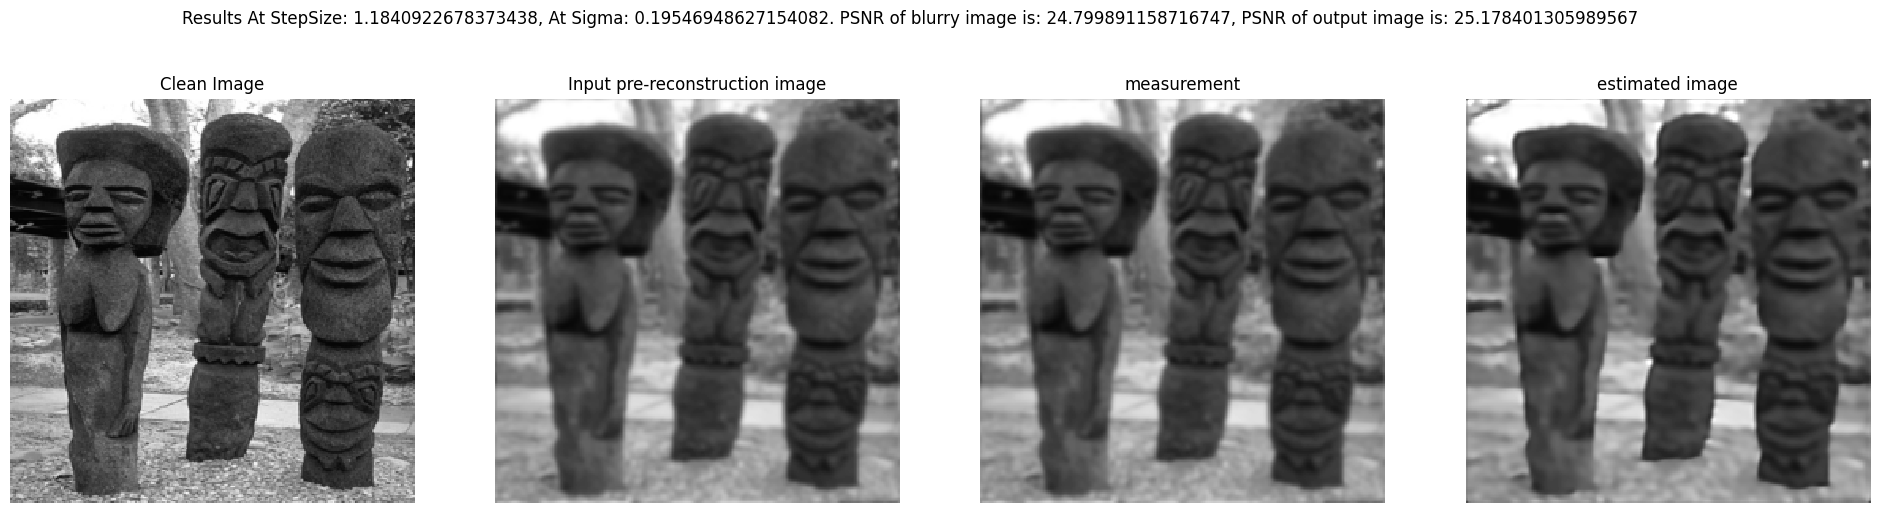

In [27]:
blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon_np = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon_np)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

fig, ax = plt.subplots(1,4, figsize=(24,6))

fig.suptitle(f'Results At StepSize: {bestStepsize}, At Sigma: {sigma}. PSNR of blurry image is: {finalPsnrMeas}, PSNR of output image is: {finalPsnrOutput}')

ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[0].set_title("Clean Image", fontsize=12)
ax[0].axis('off')
ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[1].set_title("Input pre-reconstruction image", fontsize=12)
ax[1].axis('off')
ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[2].set_title("measurement", fontsize=12)
ax[2].axis('off')
ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[3].set_title("estimated image", fontsize=12)
ax[3].axis('off')